In [218]:
import tensorflow as tf
from tensorflow.python.summary.summary_iterator import summary_iterator
from collections import defaultdict
from tensorboard.backend.event_processing.event_accumulator import EventAccumulator
from os.path import join
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from pprint import pprint
%matplotlib inline
import os
import yaml
from yaml import CLoader as Loader
from glob import glob
import regex as re

class bcolors:
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'

LOG_PATH = '../logs/'
DL_LOG_PATH = '../dl_logs/'


In [321]:
def parse_tb_logs(logs_path, metrics_to_plot, threshold=0.75):
    values = defaultdict(list)
    if os.path.isdir(join(logs_path, "metrics_synth")):
        metrics_path = join(logs_path, "metrics_synth")
    elif os.path.isdir(join(logs_path, "metrics")):
        metrics_path = join(logs_path, "metrics")
    else:
        print("ERR: logs not found")
        return [], []
        
    list_folds = os.listdir(metrics_path)
    list_folds = [el for el in list_folds if "DS_Store" not in el]
    if len(list_folds) < 1:
        shutil.rmtree(logs_path)
        print(f"{bcolors.FAIL}No folds found: unsuccessful run{bcolors.ENDC}")
        return defaultdict(list), dict()
                              
    for fold_path in list_folds:
        logs_fold_path = join(metrics_path, fold_path)
        match = re.search("fold_([0-9])", fold_path)
        fold_nb = int(match[0][-1])
        fold_string=f"fold_{fold_nb}"
        print(fold_string,  end = ' ')
    
        event_acc = EventAccumulator(logs_fold_path)
        event_acc.Reload()
        
        #print(event_acc.Tags())
        for tag in metrics_to_plot:
            try:
                _, step_nums, vals = zip(*event_acc.Scalars(tag))
                print(f'{tag} {len(vals)}, ',  end = '')
                if tag == 'val_acc':
                    print(f"Max_acc: {max(vals):.3}", end=" ")
                if len(vals) < 2 or ('acc' in tag and max(vals) < threshold):
                    print(f"{bcolors.FAIL}unsuccessful run{bcolors.ENDC}")
                    return defaultdict(list), dict()
                values[tag].append(list(np.around(vals, 4)))
                values[f'{tag}_step'].append(list(step_nums))
                values['fold_nb'].append(fold_nb)
            except:
                print(f"{bcolors.WARNING}warning: {tag} not in logs{bcolors.ENDC}", end=" ")
                #values[tag].append([])
                pass
        print()
    print()
        
    with open(join(logs_fold_path, 'hparams.yaml')) as file:
        hparams_list = yaml.load(file, Loader=Loader)
    
    fold_ckpts = [y for x in os.walk(logs_path) for y in glob(os.path.join(x[0], '*.ckpt'))]
    best_epochs = []
    patt_to_find = 'epoch='
    for fold_ckpt in fold_ckpts:
        idx_beg=fold_ckpt.rfind(patt_to_find)
        idx_end=fold_ckpt[idx_beg+1:].find('_')+idx_beg
        best_epochs.append(int(fold_ckpt[idx_beg+len(patt_to_find):idx_end+1]))
    #print("best ep", hparams_list)
    
    if len(best_epochs) > 0: hparams_list['best_epoch'] = int(np.mean(best_epochs))
    hparams_list.pop('args', None)
        
    return values, hparams_list

def interpolate_values(metrics_to_plot, values, x_values, tot_num_values=100):
    interp_values = defaultdict(list)

    for metric_name in metrics_to_plot:
        val_cond = 'val' in metric_name
        x_values = x_values if val_cond else values[f'{metric_name}_step']
        #print('max_epochs_real', max_epochs_real, val_epochs_logged)
        max_epochs_real = max(max(x_values)) 
        #max_epochs = min(max_epochs, max_epochs_real)
        x = np.linspace(0, max_epochs_real, num=tot_num_values)
        temp_lists=[]
        if val_cond:
            metric_log_steps = x_values
            #metric_log_steps = [list(set(el)) for el in metric_log_steps]
        else:
            metric_log_steps = values[f'{metric_name}_step']
        
        for steps, vals in zip(metric_log_steps, values[metric_name]):
            steps = steps[:len(vals)]
            temp_lists.append(np.interp(x, steps, vals))
        interp_values[f'{metric_name}_interp_steps'] = list(x)
        interp_values[f'{metric_name}_interp_mean'] = np.mean(temp_lists, axis=0)
        interp_values[f'{metric_name}_interp_var'] = np.var(temp_lists, axis=0)
    
    return interp_values

def plot_metrics(metrics_to_plot, interp_values_df, ax, label, epochs_values=None, color=None):
    
    for i, metric_name in enumerate(metrics_to_plot):
        if epochs_values == None:
            epochs = interp_values_df[f'{metric_name}_interp_steps']
        else:
            epochs = np.linspace(0, max(max(epochs_values)), interp_values_df.shape[0])
            #print("max val ep: ", max(epochs)) 
        mean_val = interp_values_df[f'{metric_name}_interp_mean']
        var_val = interp_values_df[f'{metric_name}_interp_var']
        ax[i].plot(epochs, mean_val, label=label, color=color) #, yerr=var_val)
        ax[i].fill_between(epochs, mean_val-var_val, mean_val+var_val, alpha=0.2, facecolor='k')
        ax[i].set_title(metric_name)
        ax[i].set_xlabel("steps")
        if 'acc' in metric_name:
            ax[i].plot(epochs, np.ones(interp_values_df.shape[0]) * 0.95, '--k', linewidth=1, alpha=0.1)
        
    return ax

def plot_agg_metrics(metrics_to_plot, logs_paths, checkpoints, 
                     name: str=None, tot_num_values=200, 
                     plot_legend=0, val_epochs_logged=False, threshold=0.75, 
                     xlabel='rel_steps', color_patt=None):
    rejected_ckpts=[]
    highscore_table = []
    f,a = plt.subplots(1, len(metrics_to_plot)-1)
    f.set_size_inches(20,6)
    f.tight_layout()
    plt.ylim(0,1.1)
    is_labeled = np.zeros(10)
    tot_len_ckpt = len(logs_paths)
    #if color_patt == 'discrete':
    #    cmap = plt.get_cmap('Dark2')
        
    for i, (logs_path, ckpt_name) in enumerate(zip(logs_paths, checkpoints)):
        print(ckpt_name)
        match=re.search(re.compile("_d([0-9]*)"), ckpt_name)
        depth=int(match.group(1)) 
        match=re.search(re.compile("_b([0-9]*)"), ckpt_name)
        b_len=int(match.group(1)) 

        metric_values, hparams_list = parse_tb_logs(logs_path, metrics_to_plot,
                                                    threshold=threshold)
        if len(list(metric_values)) == 0: 
            rejected_ckpts.append(ckpt_name)
            continue
            
        def create_run_dict(hparams_list, metric_values, ckpt_name):
            hparams_list['name'] = ckpt_name
            hparams_list['eval_steps'] = []
            hparams_list['best_score'] = max(max(metric_values['val_acc']))
            return hparams_list
        
        highscore_table.append(create_run_dict(hparams_list, metric_values, ckpt_name))   
        val_epochs_logged = 'val_epoch' in metric_values.keys()
        if 'epoch' in xlabel and val_epochs_logged:
            x_values = metric_values['val_epoch']
        else:
            x_values = metric_values['val_loss_step']
            if b_len > 0: 
                res=[]
                for fold_vals in x_values:
                    fold_vals.insert(0, 0)
                    res.append([fold_vals[i] - fold_vals[i-1] for i in range(1, len(fold_vals))])
                x_values=res
        
        interp_values = interpolate_values(metrics_to_plot=['val_loss', 'val_acc'], 
                                           values=metric_values, x_values=x_values,
                                           tot_num_values=tot_num_values)
        interp_values_df = pd.DataFrame(interp_values)
        
        label_pos = [i for i in range(len(ckpt_name)) if ckpt_name.startswith('_', i)][3]
        if color_patt == None:
            cmap = plt.get_cmap(cm_names[depth - min_d])
            lightness = (hparams_list['hidden_size'] * hparams_list['lr'] / max_h / max_lr) + 0.2
            if depth < 7: lightness += 0.3 
            color = cmap(lightness)
        elif color_patt == 'discrete':
            #color = cmap(i/8) #tot_len_ckpt)
            color = None
            
        label = None
        if plot_legend == 1:
            label = str(ckpt_name[label_pos+1:])
        if plot_legend == 2:
            if not is_labeled[depth-1]: #and lightness > 0.3:
                label = str(f"depth={depth}")
                is_labeled[depth-1] = True
        plot_metrics(metrics_to_plot=['val_loss', 'val_acc'], interp_values_df=interp_values_df, 
                     ax=a, label=label, epochs_values=x_values, color=color)
    if plot_legend > 0:
        for ax in a:
            ax.legend()        
        
    f.subplots_adjust(hspace=0.2)
    if name:
        f.savefig(f'../plots/{name}.jpg', dpi=300)
    
    return rejected_ckpts, highscore_table

In [252]:
#metrics_to_plot = ['val_loss', 'val_acc', 'val_ap', 'val_auroc', 
#                   'train_loss_epoch', 'train_acc', 'train_ap']

cm_names = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds']
metrics_to_plot = ['val_loss', 'val_acc', 'val_epoch']
max_h = 1400
max_lr = 2.0
min_d = 5


#logged paths : 208 
27127858_2104_1119_synth_um_b1_d6_h25_lr3.0
fold_0 val_loss 11, val_acc 11, Max_acc: 0.952 val_epoch 11, 

27127788_2104_0758_synth_um_b1_d7_h400_lr2.0
fold_0 val_loss 23, val_acc 23, Max_acc: 0.946 val_epoch 23, 

27127860_2104_1119_synth_um_b10_d6_h25_lr3.0
fold_0 val_loss 13, val_acc 13, Max_acc: 1.0 val_epoch 13, 

27135036_2304_1737_synth_um_b1000_d6_h50_lr1.5
fold_0 val_loss 46, val_acc 46, Max_acc: 0.567 unsuccessful run
27146953_2504_1451_synth_rand_b0_d9_h500_lr5.0
fold_2 val_loss 335, val_acc 335, Max_acc: 0.954 val_epoch 335, 
fold_0 val_loss 382, val_acc 382, Max_acc: 0.953 val_epoch 382, 
fold_1 val_loss 376, val_acc 376, Max_acc: 0.956 val_epoch 376, 

27146504_2504_1416_synth_um_b100_d7_h250_lr2.0
fold_2 val_loss 28, val_acc 28, Max_acc: 0.985 val_epoch 28, 
fold_0 val_loss 35, val_acc 35, Max_acc: 0.816 val_epoch 35, 
fold_1 val_loss 32, val_acc 32, Max_acc: 1.0 val_epoch 32, 

27135038_2304_1737_synth_um_b1000_d6_h50_lr5.0
fold_0 val_loss 35, val_a

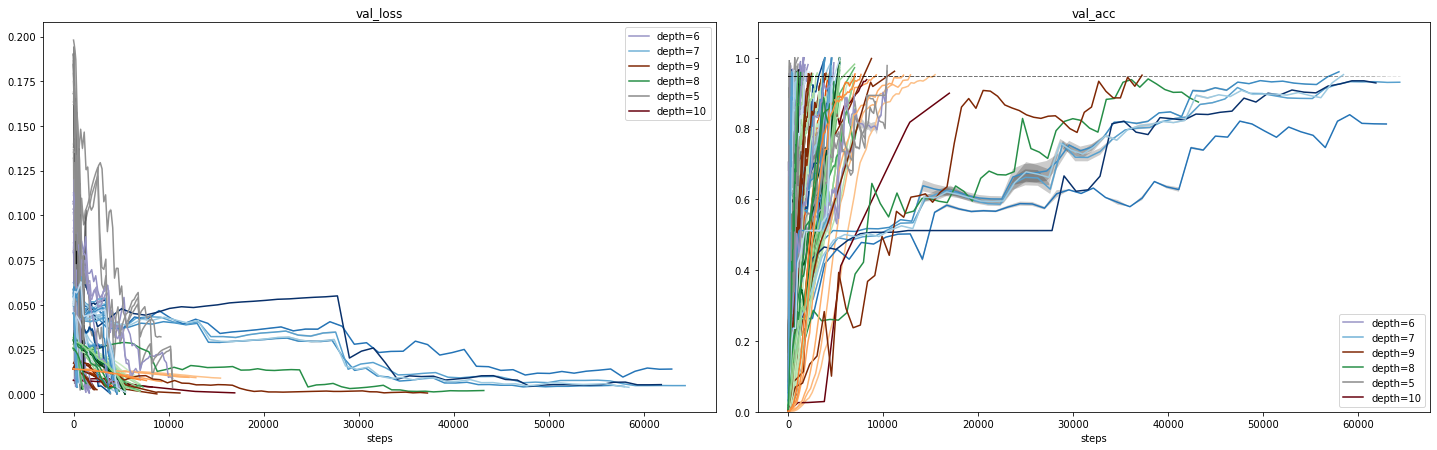

In [275]:
# loop over all files in directory

all_ckpt_dirs = os.listdir(LOG_PATH)
all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
#all_ckpt_dirs = [el for el in all_ckpt_dirs if el not in rejected_ckpts]
#all_ckpt_dirs = all_ckpt_dirs[:20]

logs_paths = [join(LOG_PATH,ckpt) for ckpt in all_ckpt_dirs]
print(f"{bcolors.OKGREEN}#logged paths : {len(logs_paths)} {bcolors.ENDC}")
rejected_ckpts, highscore_table = plot_agg_metrics(metrics_to_plot, logs_paths, 
                                                   all_ckpt_dirs, 
                                                   name="all_plots_>0.75", tot_num_values=50, 
                                                   plot_legend=2,
                                                   threshold=0.8)
plt.show()

In [ ]:
highscore_table = sorted(highscore_table, key=lambda d: d['best_epoch'], reverse=False) 
highscore_table = sorted(highscore_table, key=lambda d: (d['best_score'], d['hidden_size']), reverse=True) 


print(highscore_table[0])

print_format_str = "{:<24} {:<4} {:<5} {:<7} {:<6} {:<4} {:<5}"

print('____________________________________________________')
print(print_format_str.format('name', 'lr', 'mode','h_size','#class', 'ep', 'best_score'))
for el in highscore_table:
    name=el['name']
    idx = [i for i in range(len(name)) if name.startswith('_', i)][3]
    name=name[idx+1:]
    print (print_format_str.format(name, el['lr'], el['mode'], el['hidden_size'], 
                                    el['nb_classes'], el['best_epoch'], el['best_score']))


# Filtered graphs

#logged paths : 9 
27166074_2904_1631_synth_um_b0_d7_h100_lr2.0
fold_0 val_loss 1765, val_acc 1765, Max_acc: 0.932 val_epoch 1765, 
fold_1 val_loss 1348, val_acc 1348, Max_acc: 0.959 val_epoch 1348, 

27158443_2704_2340_synth_rand_b0_d7_h100_lr2.0
fold_2 val_loss 103, val_acc 103, Max_acc: 0.974 val_epoch 103, 
fold_0 val_loss 106, val_acc 106, Max_acc: 0.968 val_epoch 106, 
fold_1 val_loss 107, val_acc 107, Max_acc: 0.957 val_epoch 107, 

27127877_2104_1127_synth_um_b1_d7_h100_lr2.0
fold_0 val_loss 24, val_acc 24, Max_acc: 1.0 val_epoch 24, 

27174430_3004_1129_synth_um_b10_d7_h100_lr2.0
fold_0 val_loss 9, val_acc 9, Max_acc: 0.512 val_epoch 9, 

27174431_3004_1106_synth_um_b10_d7_h100_lr2.0
fold_1 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 

27174433_3004_1221_synth_um_b100_d7_h100_lr2.0
fold_1 val_loss 12, val_acc 12, Max_acc: 1.0 val_epoch 12, 

27174432_3004_1137_synth_um_b100_d7_h100_lr2.0
fold_0 val_loss 12, val_acc 12, Max_acc: 0.699 val_epoch 12, 

27174434_3004_1232_syn

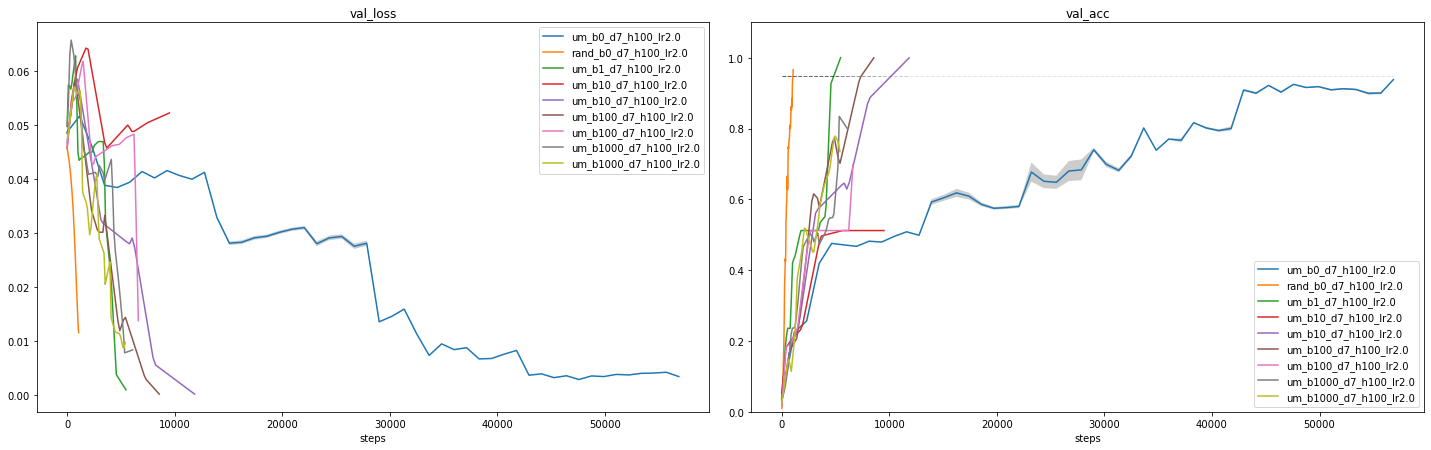

#logged paths : 7 
27172870_2904_2334_synth_um_b0_d7_h200_lr10.0
fold_0 val_loss 1799, val_acc 1799, Max_acc: 0.954 val_epoch 1799, 
fold_1 val_loss 1844, val_acc 1844, Max_acc: 0.959 val_epoch 1844, 

27158449_2704_2344_synth_rand_b0_d7_h200_lr10.0
fold_2 val_loss 31, val_acc 31, Max_acc: 0.954 val_epoch 31, 
fold_0 val_loss 33, val_acc 33, Max_acc: 0.983 val_epoch 33, 
fold_1 val_loss 29, val_acc 29, Max_acc: 0.961 val_epoch 29, 

27172868_2904_2334_synth_um_b0_d7_h200_lr5.0
fold_0 val_loss 1799, val_acc 1799, Max_acc: 0.956 val_epoch 1799, 
fold_1 val_loss 1348, val_acc 1348, Max_acc: 0.952 val_epoch 1348, 

27158448_2704_2343_synth_rand_b0_d7_h200_lr5.0
fold_2 val_loss 46, val_acc 46, Max_acc: 0.952 val_epoch 46, 
fold_0 val_loss 44, val_acc 44, Max_acc: 0.961 val_epoch 44, 
fold_1 val_loss 46, val_acc 46, Max_acc: 0.953 val_epoch 46, 

27158447_2704_2342_synth_rand_b0_d7_h200_lr2.0
fold_2 val_loss 94, val_acc 94, Max_acc: 0.956 val_epoch 94, 
fold_0 val_loss 88, val_acc 88, Max_ac

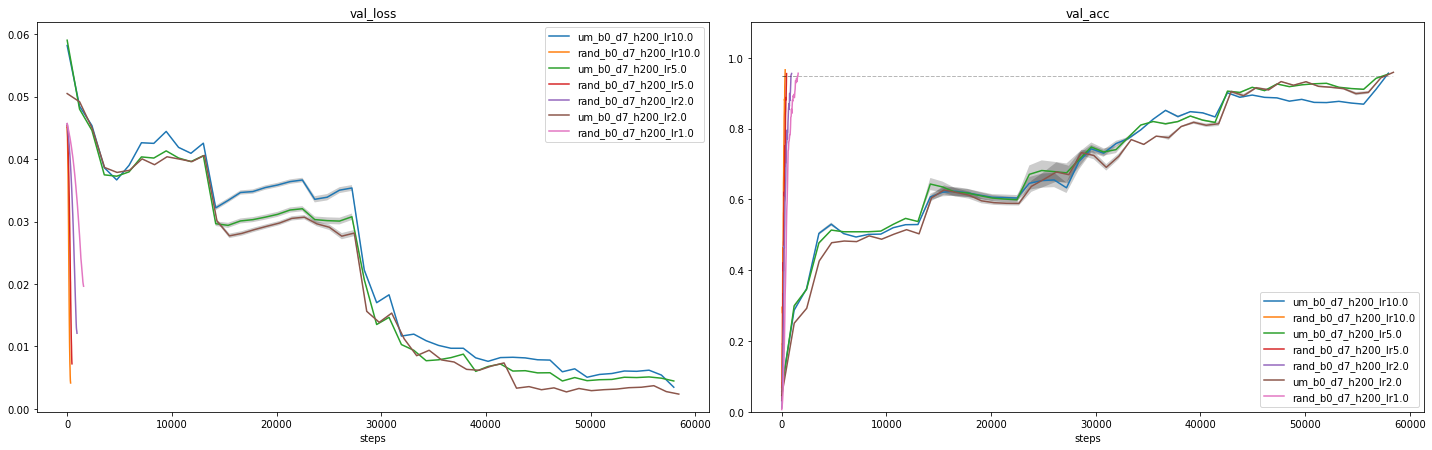

#logged paths : 6 
27158457_2704_2347_synth_rand_b0_d8_h200_lr5.0
fold_2 val_loss 144, val_acc 144, Max_acc: 0.957 val_epoch 144, 
fold_0 val_loss 138, val_acc 138, Max_acc: 0.957 val_epoch 138, 
fold_1 val_loss 151, val_acc 151, Max_acc: 0.96 val_epoch 151, 

27160156_2804_2006_synth_um_b0_d8_h200_lr5.0
fold_0 val_loss 1126, val_acc 1126, Max_acc: 0.951 val_epoch 1126, 
fold_1 val_loss 738, val_acc 738, Max_acc: 0.953 val_epoch 738, 

27166093_2904_1714_synth_um_b1_d8_h200_lr5.0
fold_0 val_loss 7, val_acc 7, Max_acc: 0.752 val_epoch 7, 
fold_1 val_loss 6, val_acc 6, Max_acc: 1.0 val_epoch 6, 

27166095_2904_1718_synth_um_b10_d8_h200_lr5.0
fold_0 val_loss 8, val_acc 8, Max_acc: 1.0 val_epoch 8, 
fold_1 val_loss 6, val_acc 6, Max_acc: 1.0 val_epoch 6, 

27166097_2904_1718_synth_um_b100_d8_h200_lr5.0
fold_0 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 
fold_1 val_loss 8, val_acc 8, Max_acc: 1.0 val_epoch 8, 

27166099_2904_1725_synth_um_b1000_d8_h200_lr5.0
fold_0 val_loss 16, val_acc

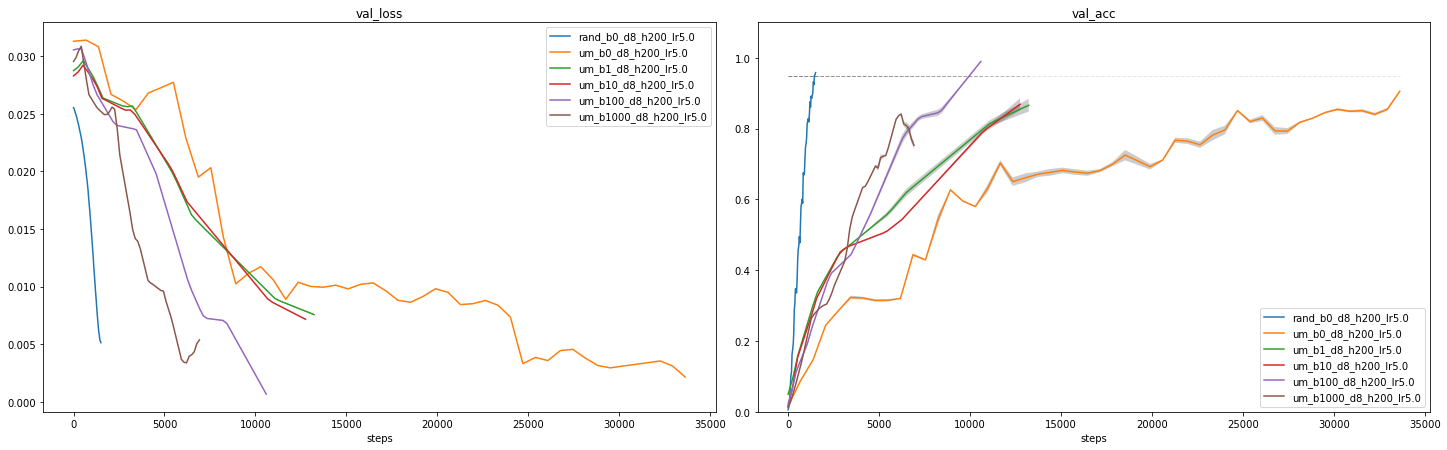

#logged paths : 9 
27146950_2504_1451_synth_rand_b0_d8_h300_lr5.0
fold_3 val_loss 123, val_acc 123, Max_acc: 0.952 val_epoch 123, 
fold_2 val_loss 121, val_acc 121, Max_acc: 0.952 val_epoch 121, 
fold_0 val_loss 125, val_acc 125, Max_acc: 0.953 val_epoch 125, 
fold_1 val_loss 131, val_acc 131, Max_acc: 0.97 val_epoch 131, 

27147228_2504_1617_synth_um_b0_d8_h300_lr5.0
fold_0 val_loss 972, val_acc 972, Max_acc: 0.947 val_epoch 972, 

27158461_2704_2350_synth_rand_b0_d8_h300_lr5.0
fold_2 val_loss 121, val_acc 121, Max_acc: 0.952 val_epoch 121, 
fold_0 val_loss 125, val_acc 125, Max_acc: 0.953 val_epoch 125, 
fold_1 val_loss 131, val_acc 131, Max_acc: 0.97 val_epoch 131, 

27127994_2104_1329_synth_um_b1_d8_h300_lr5.0
fold_0 val_loss 16, val_acc 16, Max_acc: 1.0 val_epoch 16, 

27137832_2404_1155_synth_um_b10_d8_h300_lr5.0
fold_2 val_loss 15, val_acc 15, Max_acc: 0.877 val_epoch 15, 
fold_0 val_loss 17, val_acc 17, Max_acc: 1.0 val_epoch 17, 
fold_1 val_loss 13, val_acc 13, Max_acc: 0.951 

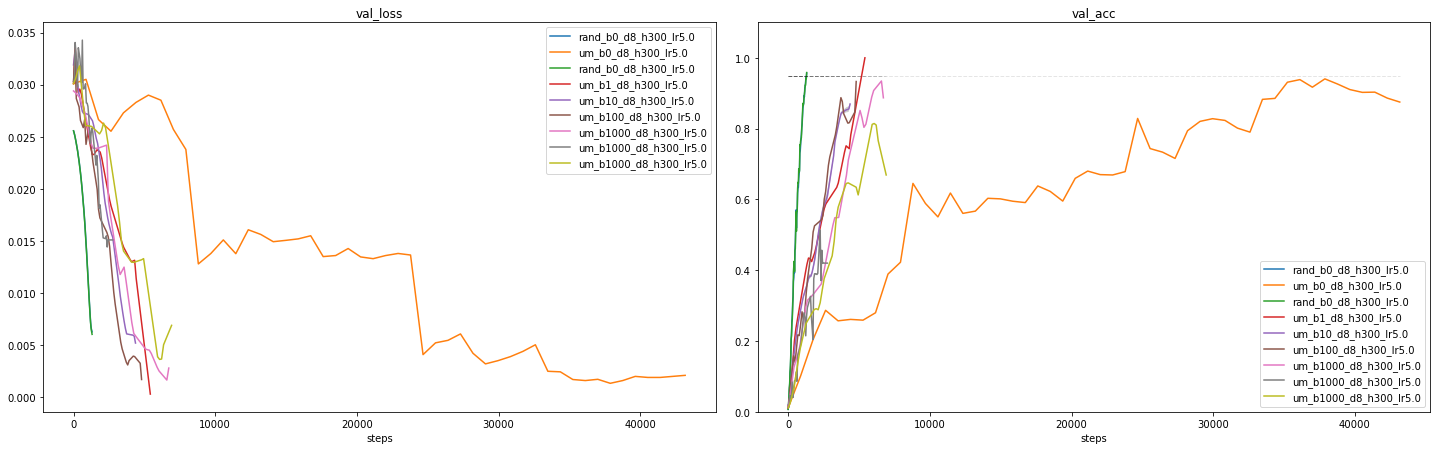

#logged paths : 8 
27158466_2704_2351_synth_rand_b0_d9_h300_lr5.0
fold_2 val_loss 418, val_acc 418, Max_acc: 0.951 val_epoch 418, 
fold_0 val_loss 436, val_acc 436, Max_acc: 0.963 val_epoch 436, 
fold_1 val_loss 422, val_acc 422, Max_acc: 0.956 val_epoch 422, 

27160165_2804_2118_synth_um_b0_d9_h300_lr5.0
fold_0 val_loss 621, val_acc 621, Max_acc: 0.951 val_epoch 621, 
fold_1 val_loss 489, val_acc 489, Max_acc: 0.953 val_epoch 489, 

27172882_3004_0108_synth_um_b0_d9_h300_lr5.0
fold_0 val_loss 621, val_acc 621, Max_acc: 0.951 val_epoch 621, 
fold_1 val_loss 489, val_acc 489, Max_acc: 0.953 val_epoch 489, 

27172827_2904_2311_synth_um_b10_d9_h300_lr5.0
fold_0 val_loss 6, val_acc 6, Max_acc: 0.861 val_epoch 6, 
fold_1 val_loss 6, val_acc 6, Max_acc: 0.968 val_epoch 6, 

27172830_2904_2314_synth_um_b100_d9_h300_lr5.0
fold_0 val_loss 7, val_acc 7, Max_acc: 0.914 val_epoch 7, 
fold_1 val_loss 7, val_acc 7, Max_acc: 0.975 val_epoch 7, 

27174493_3004_1430_synth_um_b1000_d9_h300_lr5.0
fold_0 

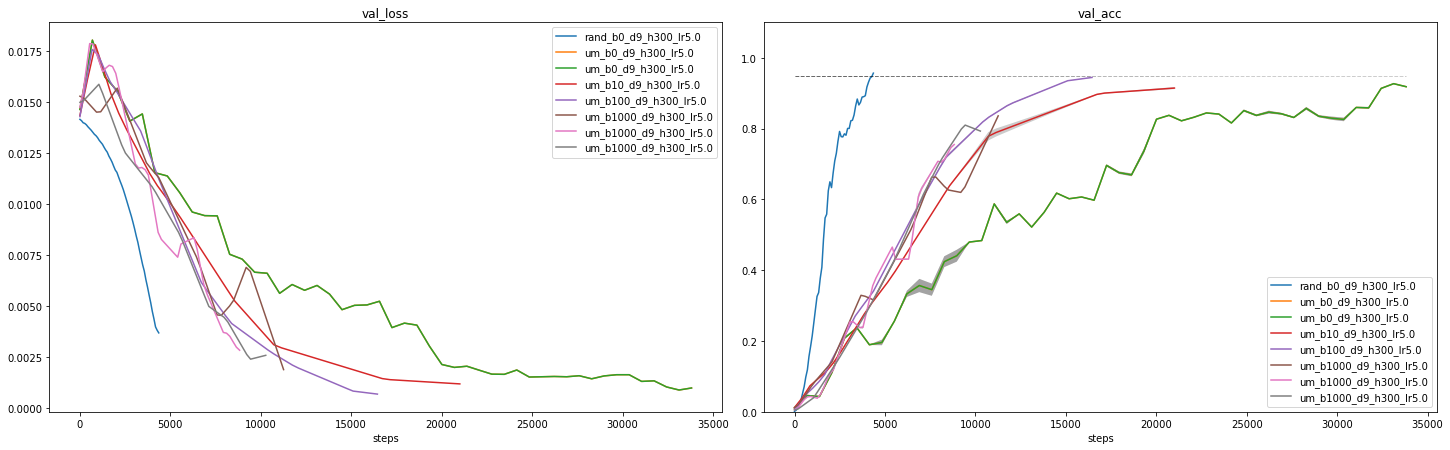

#logged paths : 8 
27146953_2504_1451_synth_rand_b0_d9_h500_lr5.0
fold_2 val_loss 335, val_acc 335, Max_acc: 0.954 val_epoch 335, 
fold_0 val_loss 382, val_acc 382, Max_acc: 0.953 val_epoch 382, 
fold_1 val_loss 376, val_acc 376, Max_acc: 0.956 val_epoch 376, 

27147230_2504_1618_synth_um_b0_d9_h500_lr5.0
fold_0 val_loss 570, val_acc 570, Max_acc: 0.951 val_epoch 570, 

27127962_2104_1218_synth_um_b1_d9_h500_lr5.0
fold_0 val_loss 13, val_acc 13, Max_acc: 0.962 val_epoch 13, 

27166102_2904_1725_synth_um_b10_d9_h500_lr5.0
fold_0 val_loss 6, val_acc 6, Max_acc: 0.876 val_epoch 6, 
fold_1 val_loss 6, val_acc 6, Max_acc: 0.969 val_epoch 6, 

27166104_2904_1732_synth_um_b100_d9_h500_lr5.0
fold_0 val_loss 8, val_acc 8, Max_acc: 0.98 val_epoch 8, 
fold_1 val_loss 7, val_acc 7, Max_acc: 0.976 val_epoch 7, 

27174495_3004_1443_synth_um_b1000_d9_h500_lr5.0
fold_0 val_loss 10, val_acc 10, Max_acc: 0.856 val_epoch 10, 

27166106_2904_1732_synth_um_b1000_d9_h500_lr5.0
fold_0 val_loss 13, val_acc 13

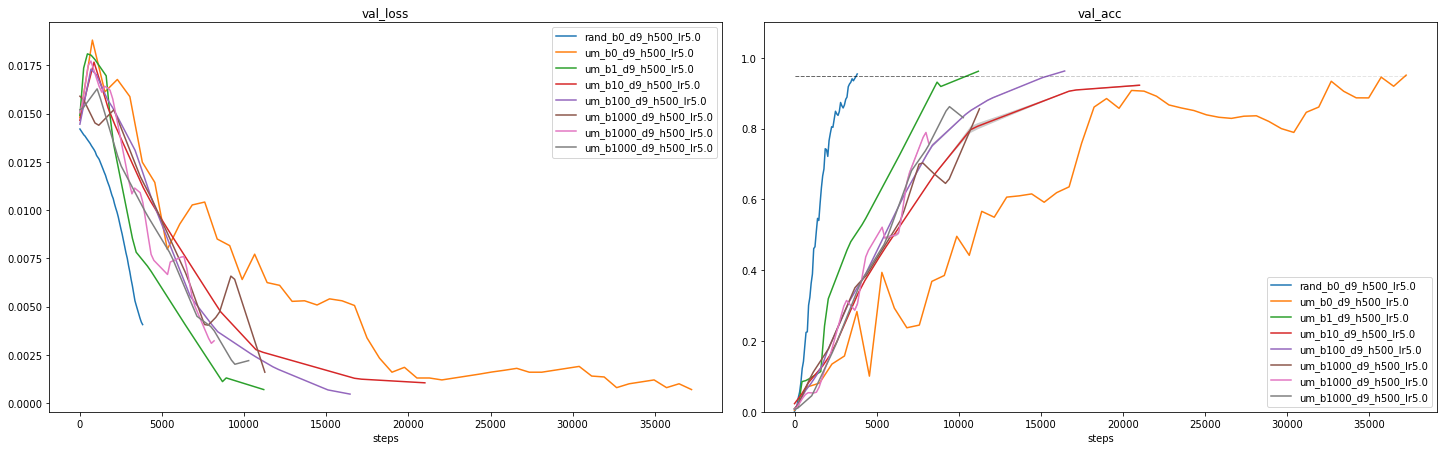

#logged paths : 2 
27172890_3004_0157_synth_um_b0_d10_h500_lr5.0
fold_0 val_loss 431, val_acc 431, Max_acc: 0.946 val_epoch 431, 
fold_1 val_loss 429, val_acc 429, Max_acc: 0.97 val_epoch 429, 

27172861_2904_2325_synth_rand_b0_d10_h500_lr5.0
fold_2 val_loss 1031, val_acc 1031, Max_acc: 0.926 val_epoch 1031, 
fold_0 val_loss 1149, val_acc 1149, Max_acc: 0.951 val_epoch 1149, 
fold_1 val_loss 1146, val_acc 1146, Max_acc: 0.956 val_epoch 1146, 



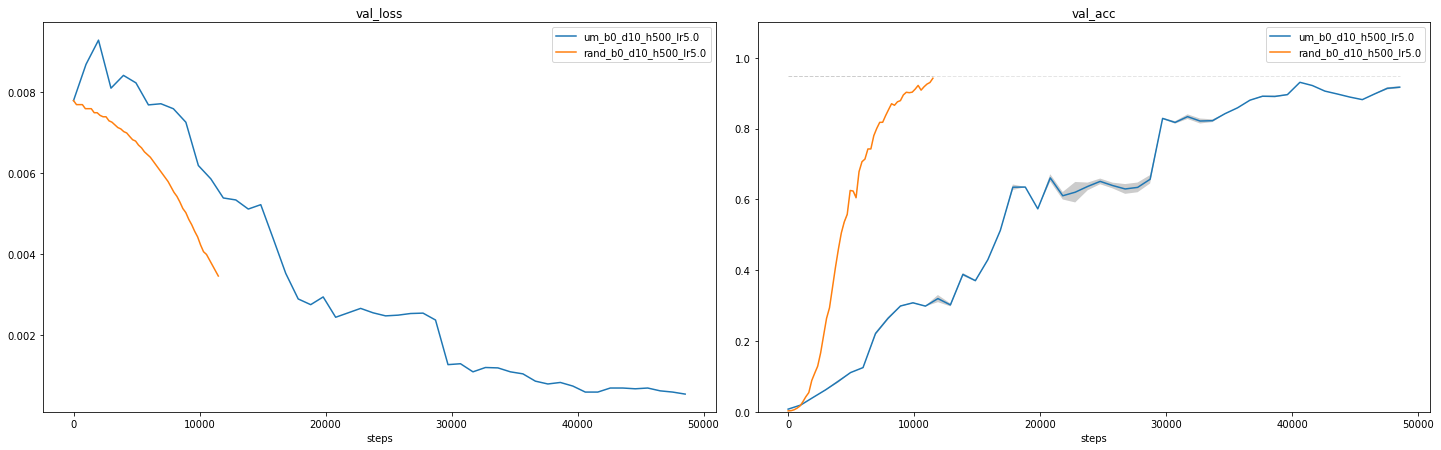

In [352]:
# example name: 27135056_2304_1747_synth_um_b1000_d5_h25_lr5


def plot_runs_w_regex(re_patt_to_search, threshold, log_path=LOG_PATH):
    plot_name=f"plot_>{threshold}_{re_patt_to_search}"
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    all_ckpt_dirs = [el for el in all_ckpt_dirs if re.search(re_patt_to_search, el)]
    
    all_ckpt_dirs = sorted(all_ckpt_dirs, key=lambda d: int(re.search('b([0-9]*)', d).group(1)), reverse=False)
    all_ckpt_dirs = sorted(all_ckpt_dirs, key=lambda d: float(re.search('lr([0-9.]*)', d).group(1)), reverse=True)

    logs_paths = [join(log_path, ckpt) for ckpt in all_ckpt_dirs]
    print(f"{bcolors.OKGREEN}#logged paths : {len(logs_paths)} {bcolors.ENDC}")
    rejected_ckpts, highscore_table = plot_agg_metrics(metrics_to_plot, logs_paths, 
                                                       all_ckpt_dirs,
                                                       name=plot_name, tot_num_values=50, 
                                                       plot_legend=1,
                                                       threshold=threshold, color_patt='discrete')
    plt.show()

patts_to_search = ["d5_h25_lr2", "d6_h25_lr2","d7_h100_lr2", "d7_h100_lr", "d8_h200_lr5", "d8_h300_lr5","d9_h300_lr5", "d9_h500_lr5", "d10_h500_lr5"]
patts_to_search = ["d7_h100_lr2", "d7_h200_lr", "d8_h200_lr5", "d8_h300_lr5","d9_h300_lr5", "d9_h500_lr5", "d10_h500_lr5"]

for patt in patts_to_search: plot_runs_w_regex(patt, 0.1) 


#logged paths : 5 
27146929_2504_1440_synth_um_b1_d5_h25_lr10.0
fold_0 val_loss 34, val_acc 34, Max_acc: 0.0906 unsuccessful run
27137821_2404_1154_synth_um_b1_d5_h25_lr5.0
fold_3 val_loss 9, val_acc 9, Max_acc: 0.981 val_epoch 9, 
fold_2 val_loss 11, val_acc 11, Max_acc: 1.0 val_epoch 11, 
fold_0 val_loss 6, val_acc 6, Max_acc: 1.0 val_epoch 6, 
fold_1 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 

27140968_2404_1655_synth_um_b1_d5_h25_lr2.0
fold_3 val_loss 10, val_acc 10, Max_acc: 1.0 val_epoch 10, 
fold_2 val_loss 11, val_acc 11, Max_acc: 1.0 val_epoch 11, 
fold_0 val_loss 6, val_acc 6, Max_acc: 0.997 val_epoch 6, 
fold_1 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 

27146928_2504_1440_synth_um_b1_d5_h25_lr1.0
fold_3 val_loss 13, val_acc 13, Max_acc: 1.0 val_epoch 13, 
fold_2 val_loss 11, val_acc 11, Max_acc: 1.0 val_epoch 11, 
fold_0 val_loss 11, val_acc 11, Max_acc: 1.0 val_epoch 11, 
fold_1 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 

27146927_2504_1440_synth_um_b1

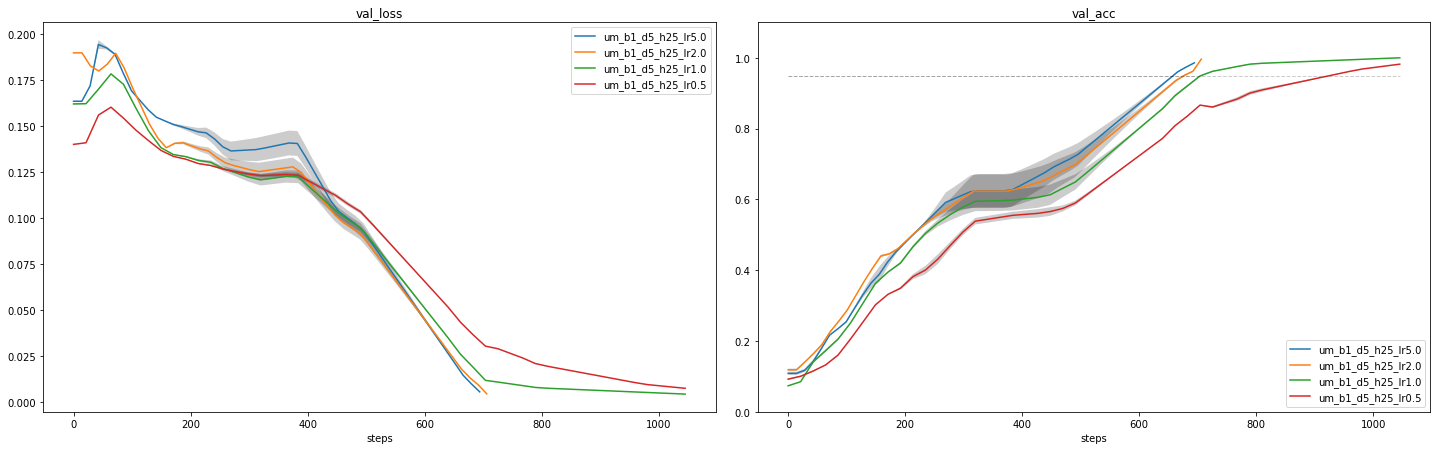

#logged paths : 2 
27137826_2404_1154_synth_um_b1_d6_h25_lr5.0
fold_3 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 
fold_2 val_loss 8, val_acc 8, Max_acc: 0.962 val_epoch 8, 
fold_0 val_loss 11, val_acc 11, Max_acc: 0.981 val_epoch 11, 
fold_1 val_loss 11, val_acc 11, Max_acc: 1.0 val_epoch 11, 

27127858_2104_1119_synth_um_b1_d6_h25_lr3.0
fold_0 val_loss 11, val_acc 11, Max_acc: 0.952 val_epoch 11, 



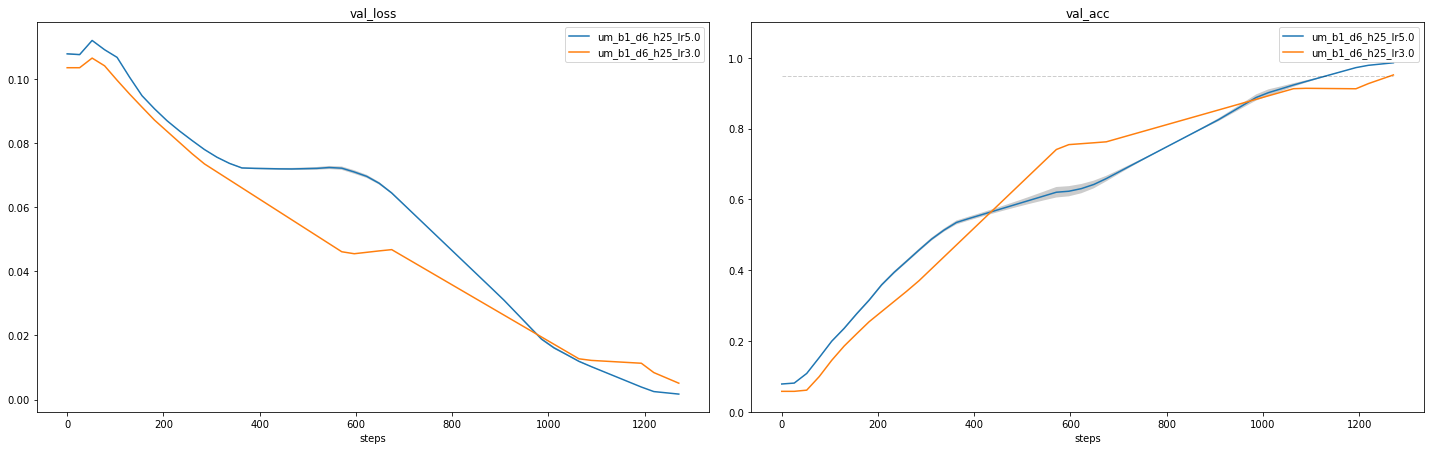

#logged paths : 4 
27127956_2104_1218_synth_um_b1_d7_h100_lr10.0
fold_0 val_loss 23, val_acc 23, Max_acc: 1.0 val_epoch 23, 

27127955_2104_1218_synth_um_b1_d7_h100_lr5.0
fold_0 val_loss 23, val_acc 23, Max_acc: 0.997 val_epoch 23, 

27127878_2104_1127_synth_um_b1_d7_h100_lr3.0
fold_0 val_loss 23, val_acc 23, Max_acc: 0.958 val_epoch 23, 

27127877_2104_1127_synth_um_b1_d7_h100_lr2.0
fold_0 val_loss 24, val_acc 24, Max_acc: 1.0 val_epoch 24, 



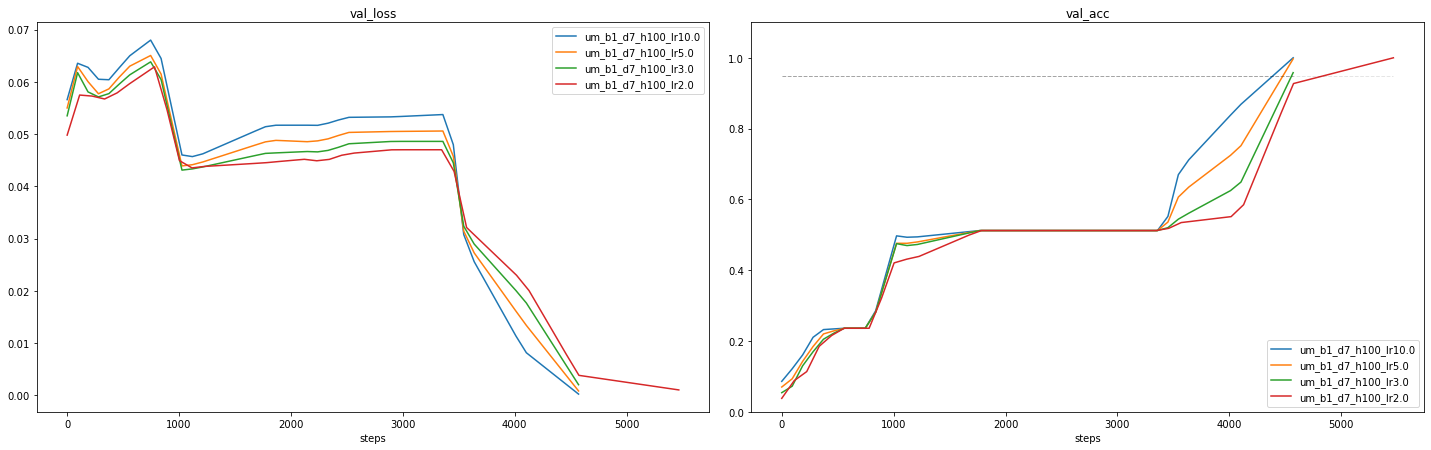

#logged paths : 4 
27147181_2504_1534_synth_um_b1_d8_h300_lr10.0
fold_0 val_loss 16, val_acc 16, Max_acc: 1.0 val_epoch 16, 

27127994_2104_1329_synth_um_b1_d8_h300_lr5.0
fold_0 val_loss 16, val_acc 16, Max_acc: 1.0 val_epoch 16, 

27127993_2104_1329_synth_um_b1_d8_h300_lr2.0
fold_0 val_loss 16, val_acc 16, Max_acc: 0.98 val_epoch 16, 

27147180_2504_1527_synth_um_b1_d8_h300_lr1.0
fold_0 val_loss 17, val_acc 17, Max_acc: 0.812 val_epoch 17, 



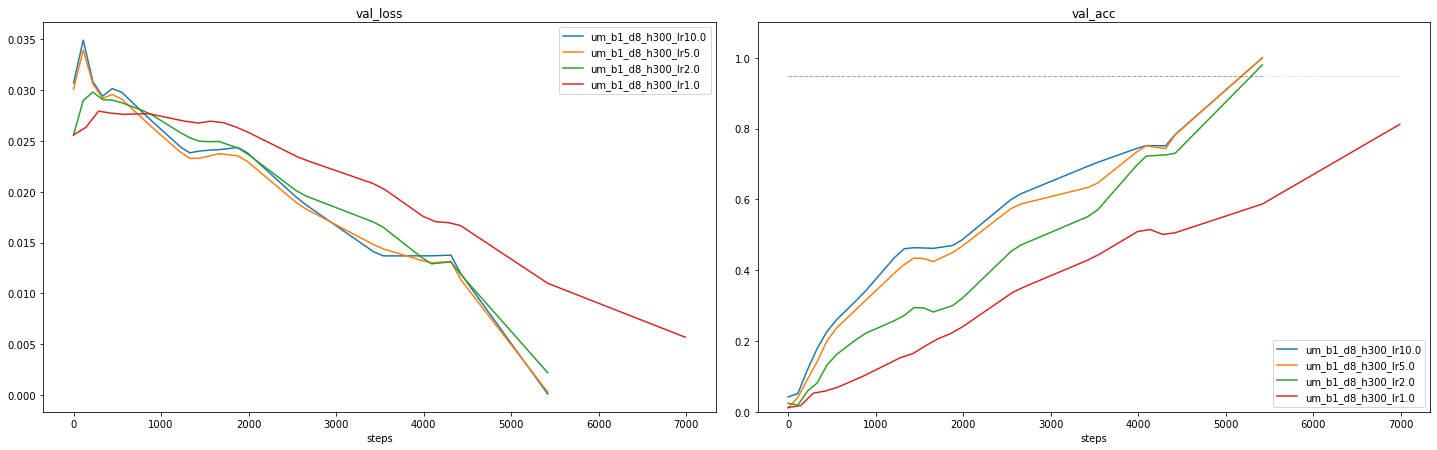

#logged paths : 5 
27127963_2104_1218_synth_um_b1_d9_h500_lr10.0
fold_0 val_loss 11, val_acc 11, Max_acc: 0.998 val_epoch 11, 

27127962_2104_1218_synth_um_b1_d9_h500_lr5.0
fold_0 val_loss 13, val_acc 13, Max_acc: 0.962 val_epoch 13, 

27127800_2104_0802_synth_um_b1_d9_h500_lr2.0
fold_0 val_loss 12, val_acc 12, Max_acc: 0.667 val_epoch 12, 

27127799_2104_0800_synth_um_b1_d9_h500_lr1.5
fold_0 val_loss 12, val_acc 12, Max_acc: 0.491 val_epoch 12, 

27127798_2104_0800_synth_um_b1_d9_h500_lr1.0
fold_0 val_loss 12, val_acc 12, Max_acc: 0.386 val_epoch 12, 



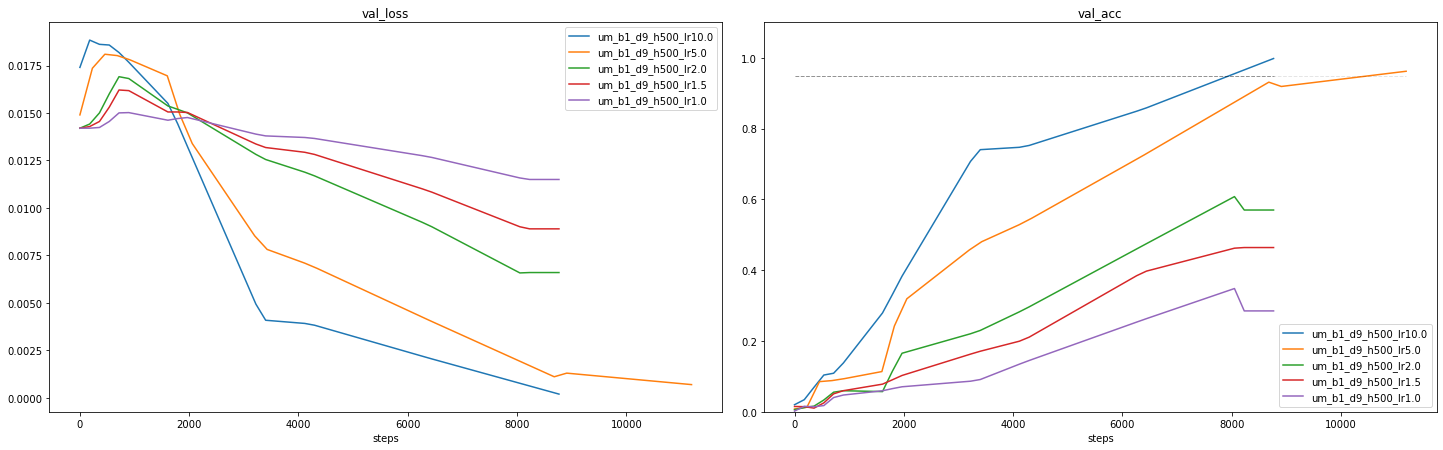

#logged paths : 4 
27127999_2104_1331_synth_um_b1_d10_h1000_lr5.0
fold_0 val_loss 10, val_acc 10, Max_acc: 0.9 val_epoch 10, 

27127998_2104_1331_synth_um_b1_d10_h1000_lr2.0
fold_0 val_loss 10, val_acc 10, Max_acc: 0.581 val_epoch 10, 

27127830_2104_1012_synth_um_b1_d10_h1000_lr1.0
fold_0 val_loss 10, val_acc 10, Max_acc: 0.429 val_epoch 10, 

27127829_2104_1012_synth_um_b1_d10_h1000_lr0.5
fold_0 val_loss 10, val_acc 10, Max_acc: 0.147 val_epoch 10, 



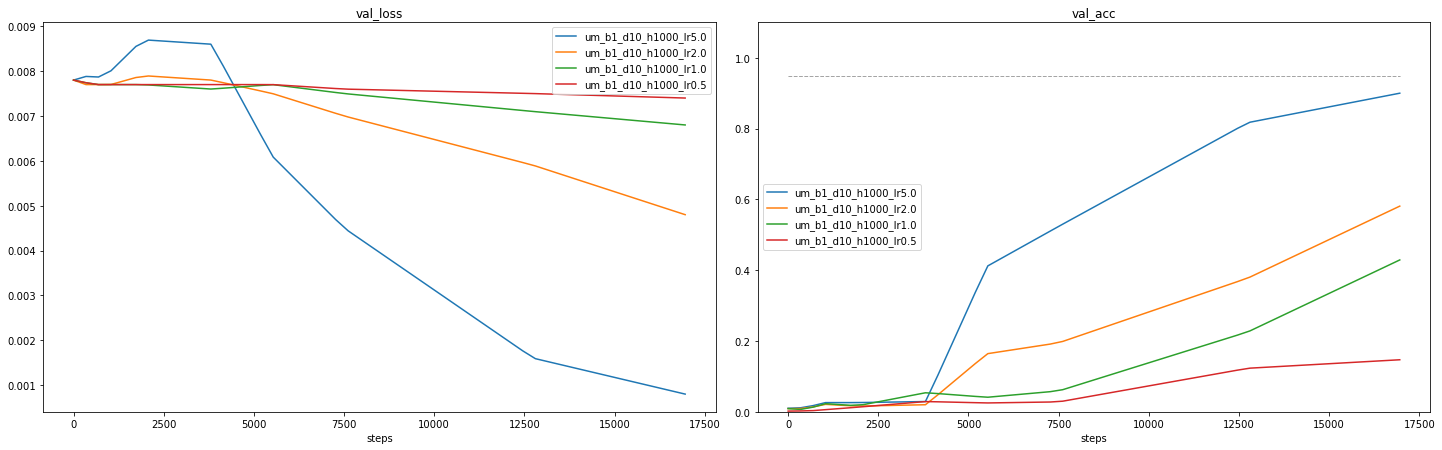

In [342]:
patts_to_search = ["b1_d5_h25_lr", "b1_d6_h25_lr",  "b1_d7_h100_lr", "b1_d8_h300_lr", "b1_d9_h500_lr", "b1_d10_h1000"]

for patt in patts_to_search: plot_runs_w_regex(patt, 0.1) 

#logged paths : 8 
27156823_2704_1355_synth_um_b0_d5_h25_lr10.0
fold_0 val_loss 1504, val_acc 1504, Max_acc: 0.1 unsuccessful run
27156822_2704_1355_synth_um_b0_d5_h25_lr5.0
fold_0 val_loss 1502, val_acc 1502, Max_acc: 0.103 unsuccessful run
27160125_2804_1104_synth_um_b0_d5_h25_lr5.0
fold_0 val_loss 236, val_acc 236, Max_acc: 0.103 unsuccessful run
27172706_2904_2239_synth_um_b0_d5_h50_lr5.0
fold_0 val_loss 1504, val_acc 1504, Max_acc: 0.197 unsuccessful run
27172704_2904_2239_synth_um_b0_d5_h50_lr2.0
fold_0 val_loss 518, val_acc 518, Max_acc: 1.0 val_epoch 518, 
fold_1 val_loss 432, val_acc 432, Max_acc: 0.975 val_epoch 432, 

27156821_2704_1354_synth_um_b0_d5_h25_lr2.0
fold_2 val_loss 400, val_acc 400, Max_acc: 0.969 val_epoch 400, 
fold_0 val_loss 456, val_acc 456, Max_acc: 0.966 val_epoch 456, 
fold_1 val_loss 428, val_acc 428, Max_acc: 0.953 val_epoch 428, 

27156820_2704_1354_synth_um_b0_d5_h25_lr1.0
fold_0 val_loss 444, val_acc 444, Max_acc: 0.962 val_epoch 444, 

27156819_2704

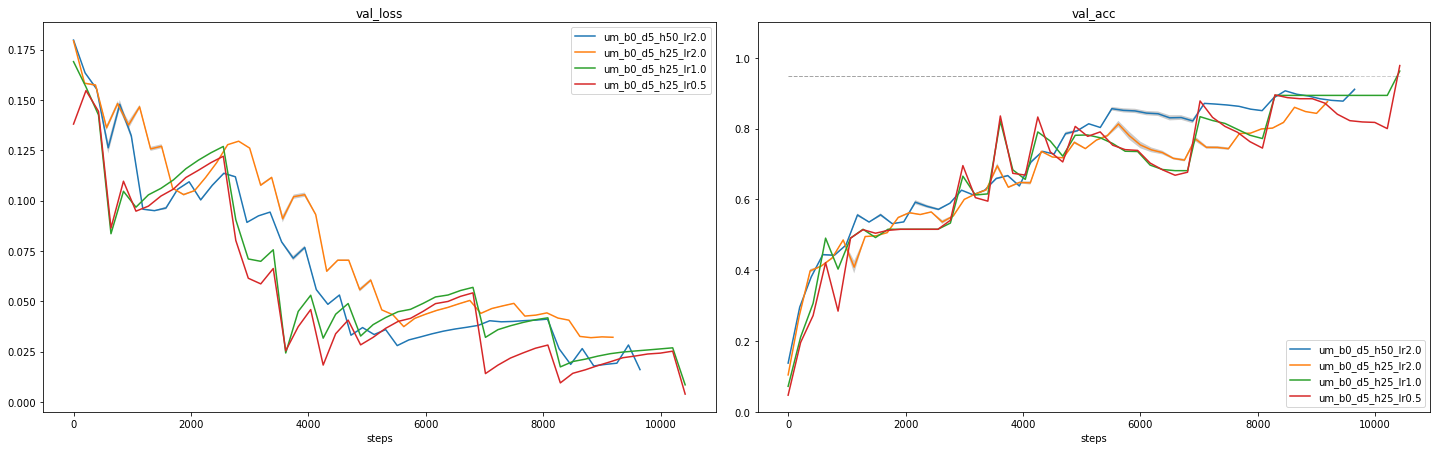

#logged paths : 6 
27158426_2704_2333_synth_um_b0_d6_h25_lr10.0
fold_0 val_loss 1516, val_acc 1516, Max_acc: 0.0797 unsuccessful run
27158424_2704_2334_synth_um_b0_d6_h25_lr5.0
fold_0 val_loss 323, val_acc 323, Max_acc: 0.973 val_epoch 323, 
fold_1 val_loss 458, val_acc 458, Max_acc: 0.978 val_epoch 458, 

27172711_2904_2242_synth_um_b0_d6_h50_lr5.0
fold_0 val_loss 216, val_acc 216, Max_acc: 0.97 val_epoch 216, 
fold_1 val_loss 380, val_acc 380, Max_acc: 0.967 val_epoch 380, 

27158422_2704_2333_synth_um_b0_d6_h25_lr2.0
fold_0 val_loss 196, val_acc 196, Max_acc: 0.952 val_epoch 196, 
fold_1 val_loss 379, val_acc 379, Max_acc: 0.969 val_epoch 379, 

27172709_2904_2241_synth_um_b0_d6_h50_lr2.0
fold_0 val_loss 194, val_acc 194, Max_acc: 0.953 val_epoch 194, 
fold_1 val_loss 379, val_acc 379, Max_acc: 0.955 val_epoch 379, 

27158420_2704_2333_synth_um_b0_d6_h25_lr1.0
fold_0 val_loss 216, val_acc 216, Max_acc: 0.958 val_epoch 216, 
fold_1 val_loss 379, val_acc 379, Max_acc: 0.967 val_epoch 

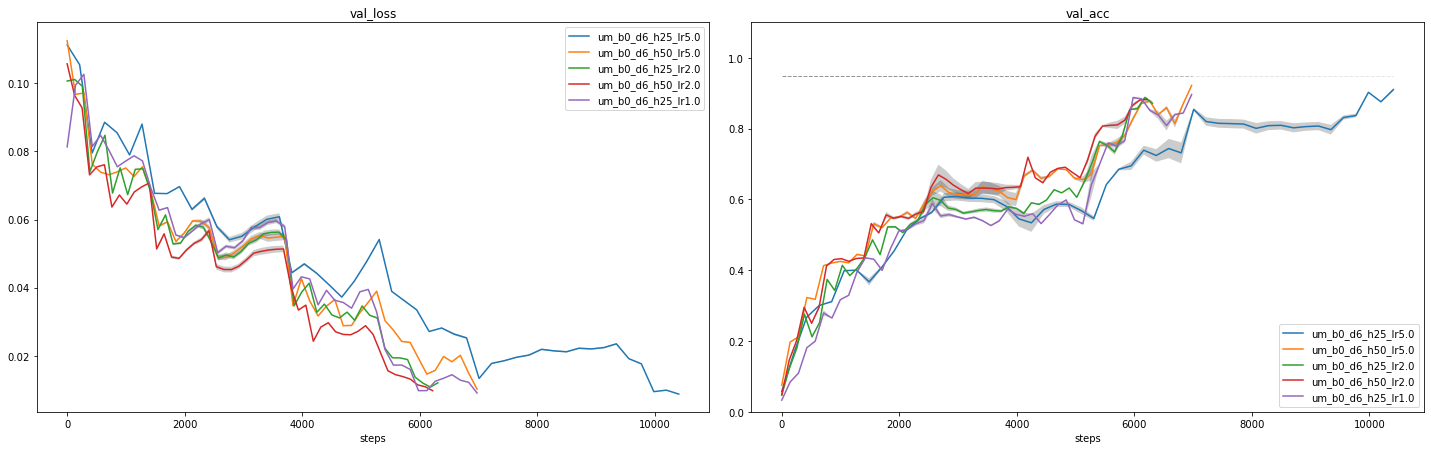

#logged paths : 19 
27157679_2704_2312_synth_um_b0_d7_h250_lr15.0
fold_0 val_loss 1873, val_acc 1873, Max_acc: 0.765 unsuccessful run
27157673_2704_2312_synth_um_b0_d7_h100_lr15.0
fold_0 val_loss 1954, val_acc 1954, Max_acc: 0.881 val_epoch 1954, 
fold_1 val_loss 1965, val_acc 1965, Max_acc: 0.859 val_epoch 1965, 

27160134_2804_1104_synth_um_b0_d7_h50_lr10.0
fold_0 val_loss 2050, val_acc 2050, Max_acc: 0.919 val_epoch 2050, 
fold_1 val_loss 2107, val_acc 2107, Max_acc: 0.943 val_epoch 2107, 

27157671_2704_2312_synth_um_b0_d7_h100_lr10.0
fold_0 val_loss 1999, val_acc 1999, Max_acc: 0.928 val_epoch 1999, 
fold_1 val_loss 1867, val_acc 1867, Max_acc: 0.961 val_epoch 1867, 

27172870_2904_2334_synth_um_b0_d7_h200_lr10.0
fold_0 val_loss 1799, val_acc 1799, Max_acc: 0.954 val_epoch 1799, 
fold_1 val_loss 1844, val_acc 1844, Max_acc: 0.959 val_epoch 1844, 

27149336_2604_1539_synth_um_b0_d7_h250_lr10.0
fold_0 val_loss 763, val_acc 763, Max_acc: 0.512 unsuccessful run
27172868_2904_2334_synt

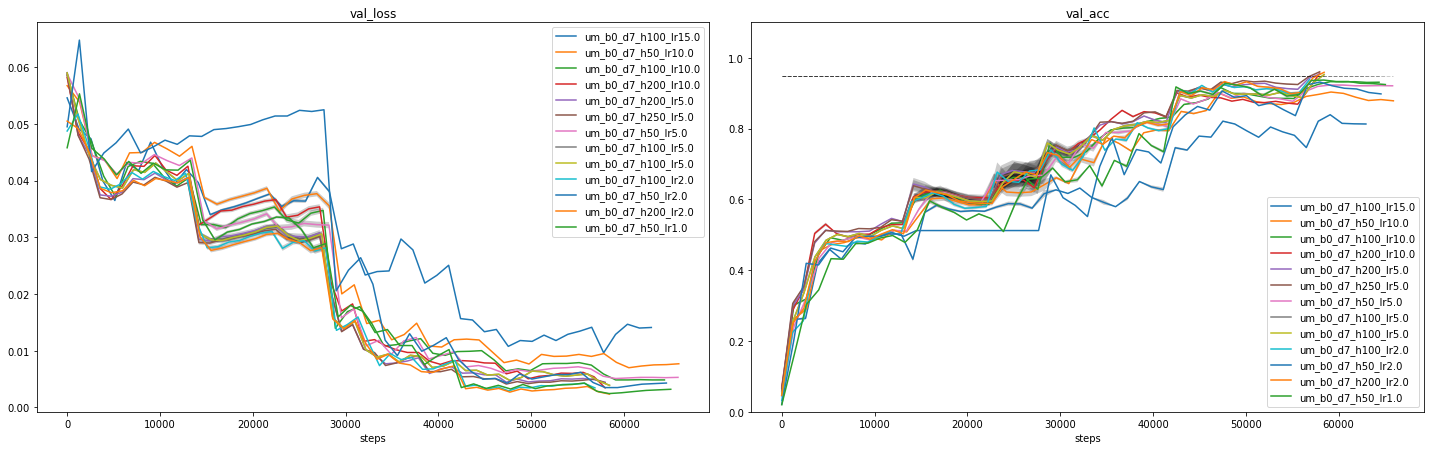

#logged paths : 12 
27160143_2804_1705_synth_um_b0_d8_h100_lr10.0
fold_0 val_loss 1181, val_acc 1181, Max_acc: 0.951 val_epoch 1181, 
fold_1 val_loss 725, val_acc 725, Max_acc: 0.958 val_epoch 725, 

27172877_2904_2355_synth_um_b0_d8_h400_lr10.0
fold_0 val_loss 1123, val_acc 1123, Max_acc: 0.953 val_epoch 1123, 
fold_1 val_loss 723, val_acc 723, Max_acc: 0.951 val_epoch 723, 

27160158_2804_2018_synth_um_b0_d8_h200_lr10.0
fold_0 val_loss 1125, val_acc 1125, Max_acc: 0.951 val_epoch 1125, 
fold_1 val_loss 734, val_acc 734, Max_acc: 0.951 val_epoch 734, 

27147228_2504_1617_synth_um_b0_d8_h300_lr5.0
fold_0 val_loss 972, val_acc 972, Max_acc: 0.947 val_epoch 972, 

27160141_2804_1642_synth_um_b0_d8_h100_lr5.0
fold_0 val_loss 1328, val_acc 1328, Max_acc: 0.933 val_epoch 1328, 
fold_1 val_loss 843, val_acc 843, Max_acc: 0.954 val_epoch 843, 

27160156_2804_2006_synth_um_b0_d8_h200_lr5.0
fold_0 val_loss 1126, val_acc 1126, Max_acc: 0.951 val_epoch 1126, 
fold_1 val_loss 738, val_acc 738, Max

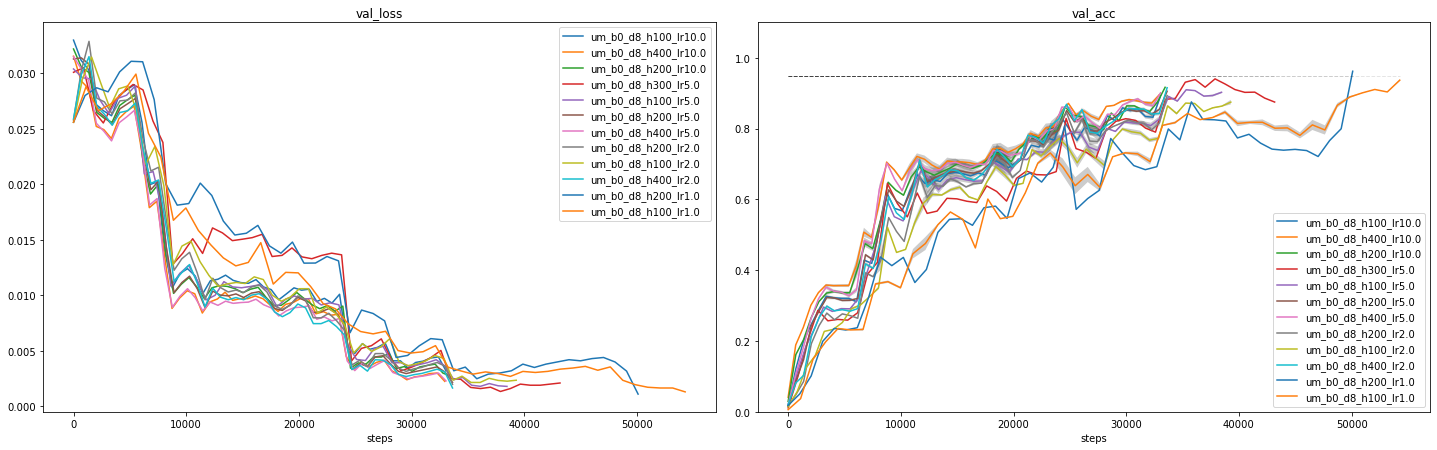

#logged paths : 8 
27160167_2804_2149_synth_um_b0_d9_h300_lr10.0
fold_0 val_loss 617, val_acc 617, Max_acc: 0.951 val_epoch 617, 
fold_1 val_loss 477, val_acc 477, Max_acc: 0.955 val_epoch 477, 

27172884_3004_0131_synth_um_b0_d9_h300_lr10.0
fold_0 val_loss 617, val_acc 617, Max_acc: 0.951 val_epoch 617, 
fold_1 val_loss 477, val_acc 477, Max_acc: 0.955 val_epoch 477, 

27160165_2804_2118_synth_um_b0_d9_h300_lr5.0
fold_0 val_loss 621, val_acc 621, Max_acc: 0.951 val_epoch 621, 
fold_1 val_loss 489, val_acc 489, Max_acc: 0.953 val_epoch 489, 

27172882_3004_0108_synth_um_b0_d9_h300_lr5.0
fold_0 val_loss 621, val_acc 621, Max_acc: 0.951 val_epoch 621, 
fold_1 val_loss 489, val_acc 489, Max_acc: 0.953 val_epoch 489, 

27147230_2504_1618_synth_um_b0_d9_h500_lr5.0
fold_0 val_loss 570, val_acc 570, Max_acc: 0.951 val_epoch 570, 

27172880_3004_0024_synth_um_b0_d9_h300_lr2.0
fold_0 val_loss 729, val_acc 729, Max_acc: 0.958 val_epoch 729, 
fold_1 val_loss 664, val_acc 664, Max_acc: 0.952 val_e

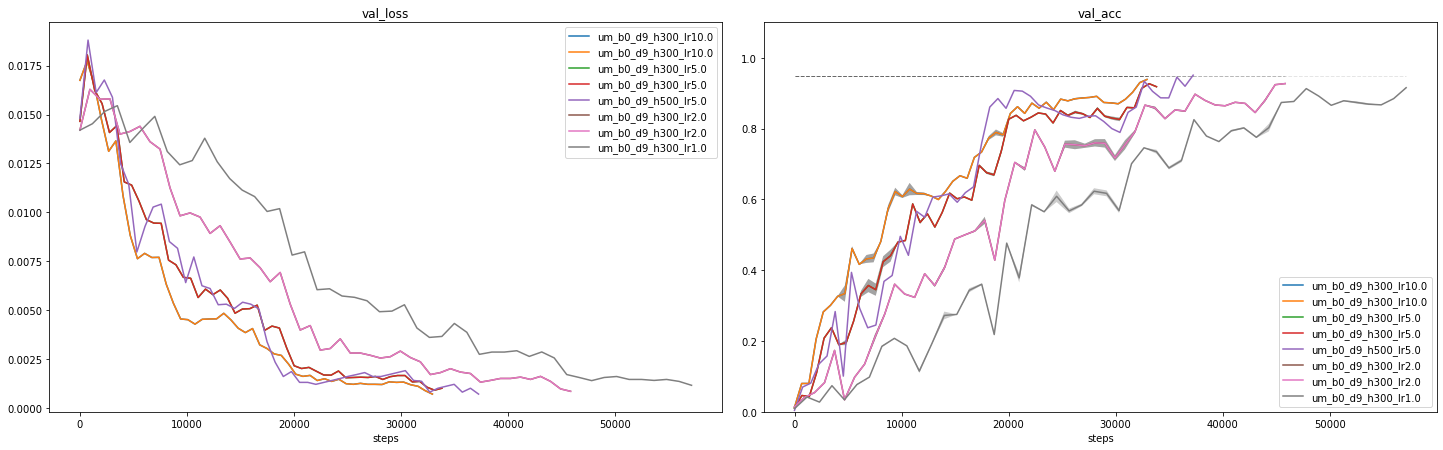

#logged paths : 6 
27172892_3004_0226_synth_um_b0_d10_h500_lr10.0
fold_0 val_loss 334, val_acc 334, Max_acc: 0.952 val_epoch 334, 
fold_1 val_loss 292, val_acc 292, Max_acc: 0.954 val_epoch 292, 

27172898_3004_0345_synth_um_b0_d10_h1000_lr10.0
fold_0 val_loss 332, val_acc 332, Max_acc: 0.96 val_epoch 332, 
fold_1 val_loss 289, val_acc 289, Max_acc: 0.955 val_epoch 289, 

27172896_3004_0319_synth_um_b0_d10_h1000_lr5.0
fold_0 val_loss 332, val_acc 332, Max_acc: 0.953 val_epoch 332, 
fold_1 val_loss 428, val_acc 428, Max_acc: 0.951 val_epoch 428, 

27172890_3004_0157_synth_um_b0_d10_h500_lr5.0
fold_0 val_loss 431, val_acc 431, Max_acc: 0.946 val_epoch 431, 
fold_1 val_loss 429, val_acc 429, Max_acc: 0.97 val_epoch 429, 

27172894_3004_0304_synth_um_b0_d10_h1000_lr2.0
fold_0 val_loss 432, val_acc 432, Max_acc: 0.9 val_epoch 432, 
fold_1 val_loss 443, val_acc 443, Max_acc: 0.915 val_epoch 443, 

27172888_3004_0148_synth_um_b0_d10_h500_lr2.0
fold_0 val_loss 426, val_acc 426, Max_acc: 0.834 

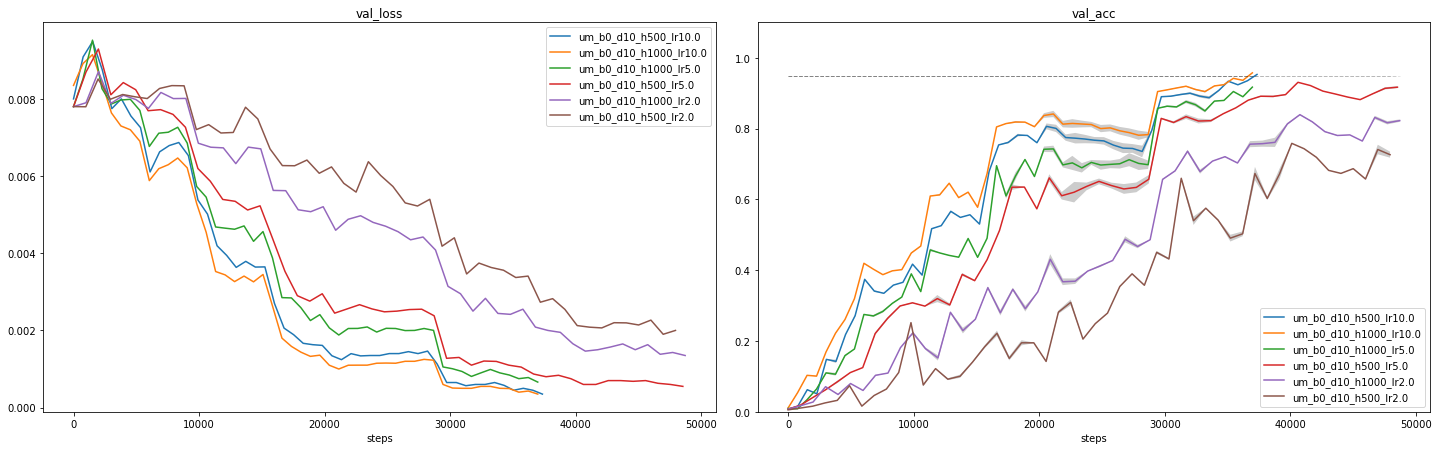

In [344]:
patts_to_search = ["um_b0_d5", "um_b0_d6",  "um_b0_d7", "um_b0_d8", "um_b0_d9", "um_b0_d10"]
for patt in patts_to_search: plot_runs_w_regex(patt, 0.8) 

#logged paths : 5 
27158432_2704_2337_synth_rand_b0_d5_h25_lr10.0
fold_2 val_loss 1504, val_acc 1504, Max_acc: 0.272 val_epoch 1504, 
fold_0 val_loss 1507, val_acc 1507, Max_acc: 0.25 val_epoch 1507, 
fold_1 val_loss 1503, val_acc 1503, Max_acc: 0.188 unsuccessful run
27158431_2704_2337_synth_rand_b0_d5_h25_lr5.0
fold_2 val_loss 9, val_acc 9, Max_acc: 0.997 val_epoch 9, 
fold_0 val_loss 11, val_acc 11, Max_acc: 1.0 val_epoch 11, 
fold_1 val_loss 12, val_acc 12, Max_acc: 0.978 val_epoch 12, 

27158430_2704_2336_synth_rand_b0_d5_h25_lr2.0
fold_2 val_loss 12, val_acc 12, Max_acc: 0.962 val_epoch 12, 
fold_0 val_loss 16, val_acc 16, Max_acc: 1.0 val_epoch 16, 
fold_1 val_loss 14, val_acc 14, Max_acc: 0.966 val_epoch 14, 

27166147_2904_1735_synth_rand_b0_d5_h10_lr2.0
fold_2 val_loss 19, val_acc 19, Max_acc: 0.997 val_epoch 19, 
fold_0 val_loss 19, val_acc 19, Max_acc: 0.966 val_epoch 19, 
fold_1 val_loss 18, val_acc 18, Max_acc: 1.0 val_epoch 18, 

27158429_2704_2336_synth_rand_b0_d5_h25_l

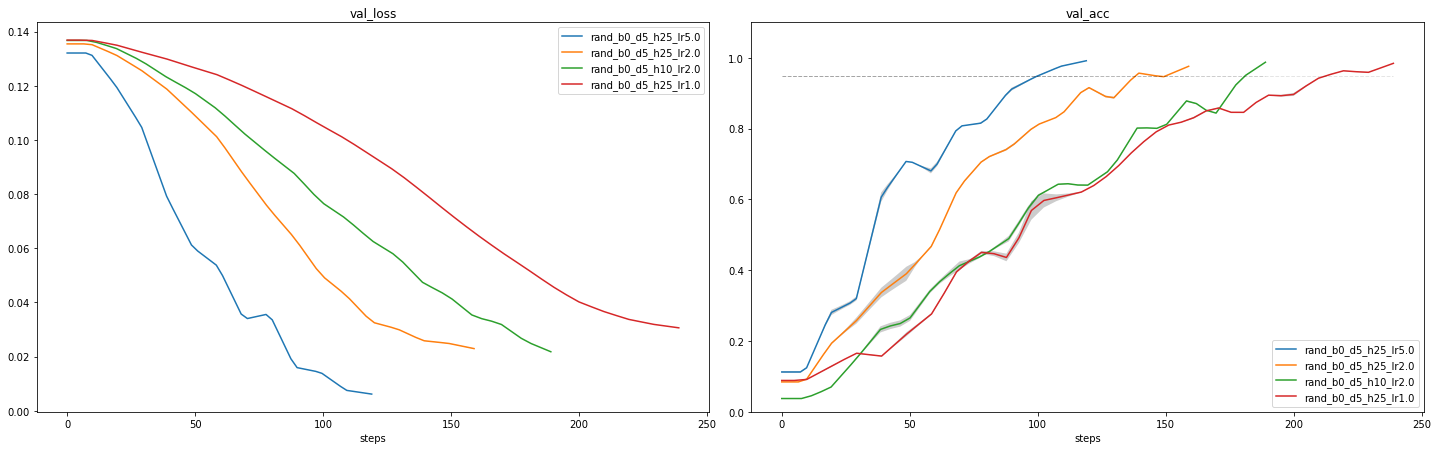

#logged paths : 6 
27158436_2704_2337_synth_rand_b0_d6_h25_lr10.0
fold_2 val_loss 21, val_acc 21, Max_acc: 0.991 val_epoch 21, 
fold_0 val_loss 22, val_acc 22, Max_acc: 0.955 val_epoch 22, 
fold_1 val_loss 20, val_acc 20, Max_acc: 0.952 val_epoch 20, 

27158435_2704_2337_synth_rand_b0_d6_h25_lr5.0
fold_2 val_loss 25, val_acc 25, Max_acc: 0.98 val_epoch 25, 
fold_0 val_loss 28, val_acc 28, Max_acc: 0.97 val_epoch 28, 
fold_1 val_loss 25, val_acc 25, Max_acc: 0.98 val_epoch 25, 

27158434_2704_2337_synth_rand_b0_d6_h25_lr2.0
fold_2 val_loss 36, val_acc 36, Max_acc: 0.956 val_epoch 36, 
fold_0 val_loss 47, val_acc 47, Max_acc: 0.969 val_epoch 47, 
fold_1 val_loss 43, val_acc 43, Max_acc: 0.978 val_epoch 43, 

27166148_2904_1739_synth_rand_b0_d6_h10_lr2.0
fold_2 val_loss 72, val_acc 72, Max_acc: 0.962 val_epoch 72, 
fold_0 val_loss 60, val_acc 60, Max_acc: 0.956 val_epoch 60, 
fold_1 val_loss 49, val_acc 49, Max_acc: 0.952 val_epoch 49, 

27166146_2904_1735_synth_rand_b0_d6_h5_lr2.0
fold_2

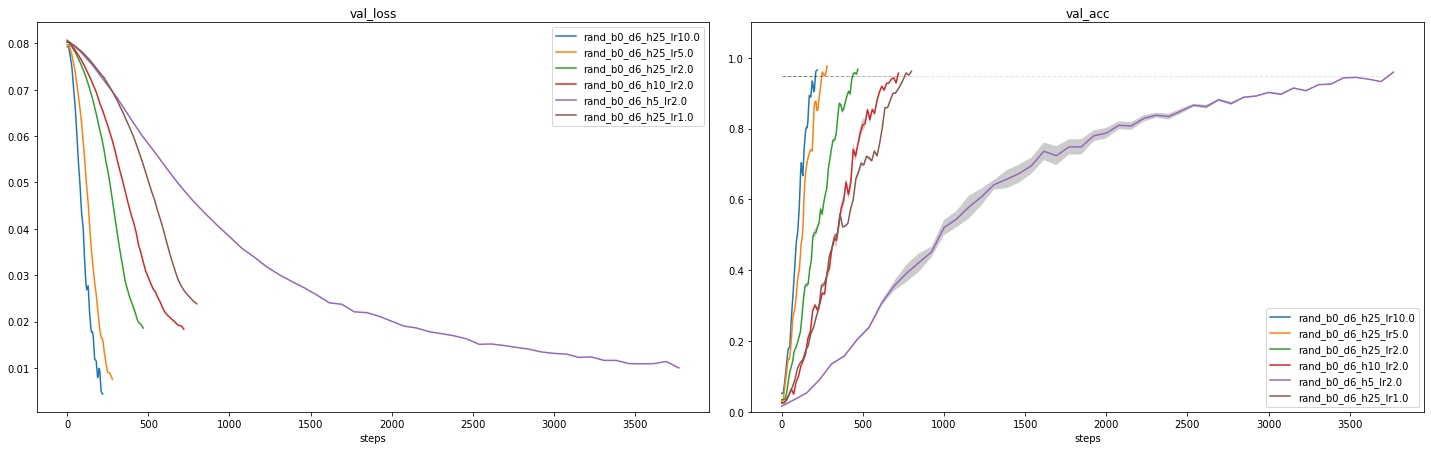

#logged paths : 7 
27158418_2704_2327_synth_rand_b0_d7_h250_lr5.0
fold_2 val_loss 43, val_acc 43, Max_acc: 0.952 val_epoch 43, 
fold_0 val_loss 44, val_acc 44, Max_acc: 0.954 val_epoch 44, 
fold_1 val_loss 46, val_acc 46, Max_acc: 0.971 val_epoch 46, 

27166157_2904_1746_synth_rand_b0_d7_h25_lr5.0
fold_2 val_loss 76, val_acc 76, Max_acc: 0.959 val_epoch 76, 
fold_0 val_loss 67, val_acc 67, Max_acc: 0.961 val_epoch 67, 
fold_1 val_loss 73, val_acc 73, Max_acc: 0.952 val_epoch 73, 

27158444_2704_2341_synth_rand_b0_d7_h100_lr5.0
fold_2 val_loss 53, val_acc 53, Max_acc: 0.954 val_epoch 53, 
fold_0 val_loss 50, val_acc 50, Max_acc: 0.954 val_epoch 50, 
fold_1 val_loss 53, val_acc 53, Max_acc: 0.957 val_epoch 53, 

27166158_2904_1746_synth_rand_b0_d7_h40_lr5.0
fold_2 val_loss 61, val_acc 61, Max_acc: 0.962 val_epoch 61, 
fold_0 val_loss 66, val_acc 66, Max_acc: 0.963 val_epoch 66, 
fold_1 val_loss 63, val_acc 63, Max_acc: 0.959 val_epoch 63, 

27146948_2504_1450_synth_rand_b0_d7_h250_lr5.0


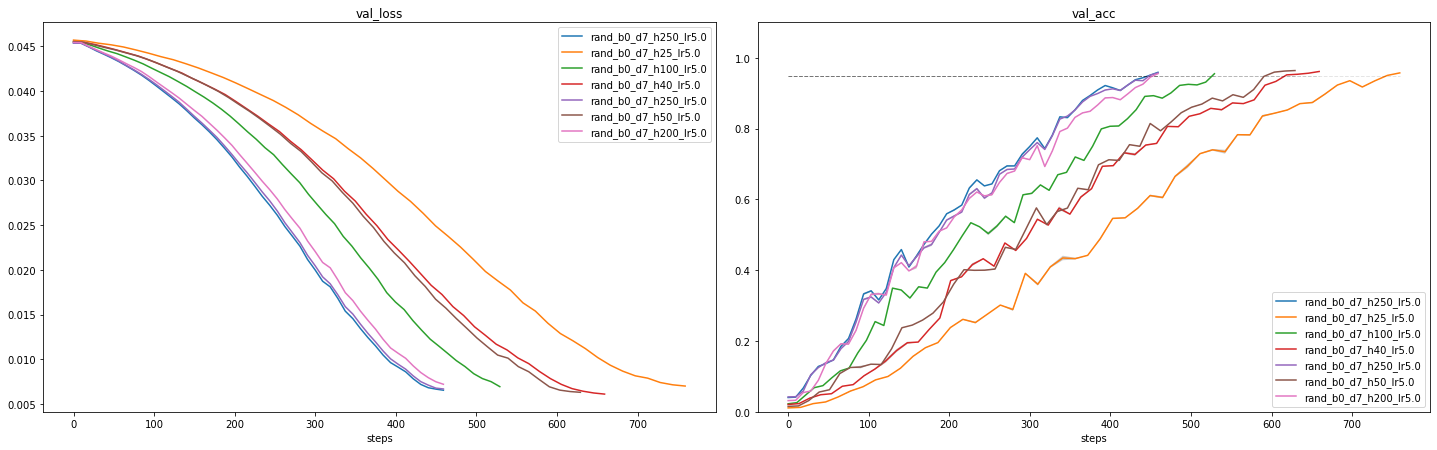

#logged paths : 4 
27158445_2704_2342_synth_rand_b0_d7_h100_lr10.0
fold_2 val_loss 39, val_acc 39, Max_acc: 0.954 val_epoch 39, 
fold_0 val_loss 34, val_acc 34, Max_acc: 0.968 val_epoch 34, 
fold_1 val_loss 34, val_acc 34, Max_acc: 0.956 val_epoch 34, 

27158444_2704_2341_synth_rand_b0_d7_h100_lr5.0
fold_2 val_loss 53, val_acc 53, Max_acc: 0.954 val_epoch 53, 
fold_0 val_loss 50, val_acc 50, Max_acc: 0.954 val_epoch 50, 
fold_1 val_loss 53, val_acc 53, Max_acc: 0.957 val_epoch 53, 

27158443_2704_2340_synth_rand_b0_d7_h100_lr2.0
fold_2 val_loss 103, val_acc 103, Max_acc: 0.974 val_epoch 103, 
fold_0 val_loss 106, val_acc 106, Max_acc: 0.968 val_epoch 106, 
fold_1 val_loss 107, val_acc 107, Max_acc: 0.957 val_epoch 107, 

27158442_2704_2340_synth_rand_b0_d7_h100_lr1.0
fold_2 val_loss 167, val_acc 167, Max_acc: 0.966 val_epoch 167, 
fold_0 val_loss 178, val_acc 178, Max_acc: 0.969 val_epoch 178, 
fold_1 val_loss 191, val_acc 191, Max_acc: 0.952 val_epoch 191, 



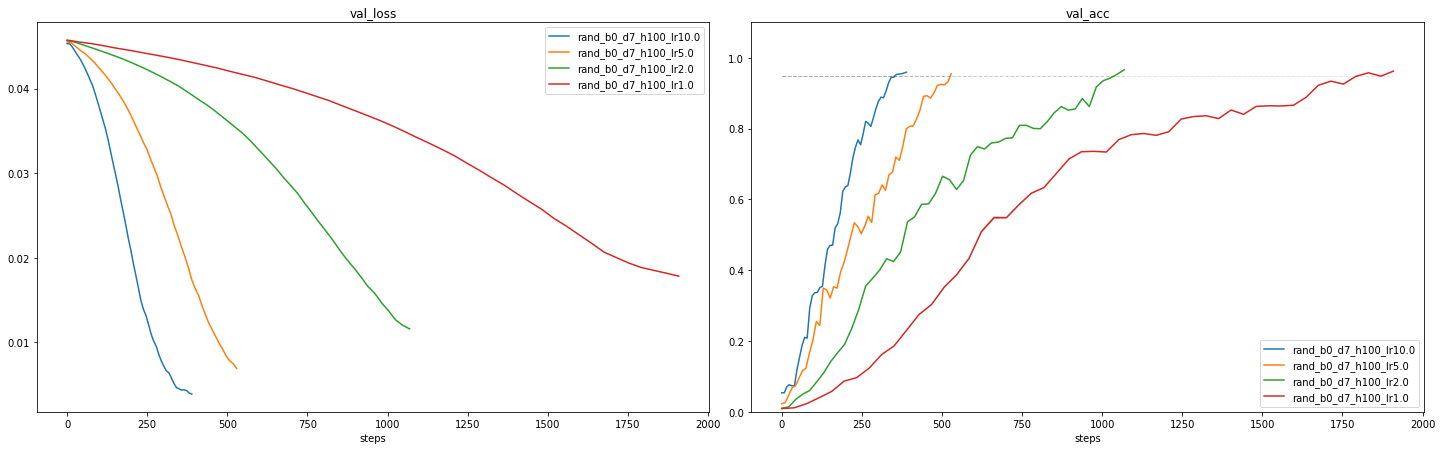

#logged paths : 16 
27158458_2704_2348_synth_rand_b0_d8_h200_lr10.0
fold_2 val_loss 95, val_acc 95, Max_acc: 0.958 val_epoch 95, 
fold_0 val_loss 89, val_acc 89, Max_acc: 0.954 val_epoch 89, 
fold_1 val_loss 86, val_acc 86, Max_acc: 0.952 val_epoch 86, 

27158462_2704_2350_synth_rand_b0_d8_h300_lr10.0
fold_2 val_loss 83, val_acc 83, Max_acc: 0.971 val_epoch 83, 
fold_0 val_loss 79, val_acc 79, Max_acc: 0.955 val_epoch 79, 
fold_1 val_loss 78, val_acc 78, Max_acc: 0.954 val_epoch 78, 

27158454_2704_2346_synth_rand_b0_d8_h100_lr10.0
fold_2 val_loss 101, val_acc 101, Max_acc: 0.962 val_epoch 101, 
fold_0 val_loss 100, val_acc 100, Max_acc: 0.957 val_epoch 100, 
fold_1 val_loss 100, val_acc 100, Max_acc: 0.958 val_epoch 100, 

27146950_2504_1451_synth_rand_b0_d8_h300_lr5.0
fold_3 val_loss 123, val_acc 123, Max_acc: 0.952 val_epoch 123, 
fold_2 val_loss 121, val_acc 121, Max_acc: 0.952 val_epoch 121, 
fold_0 val_loss 125, val_acc 125, Max_acc: 0.953 val_epoch 125, 
fold_1 val_loss 131, val

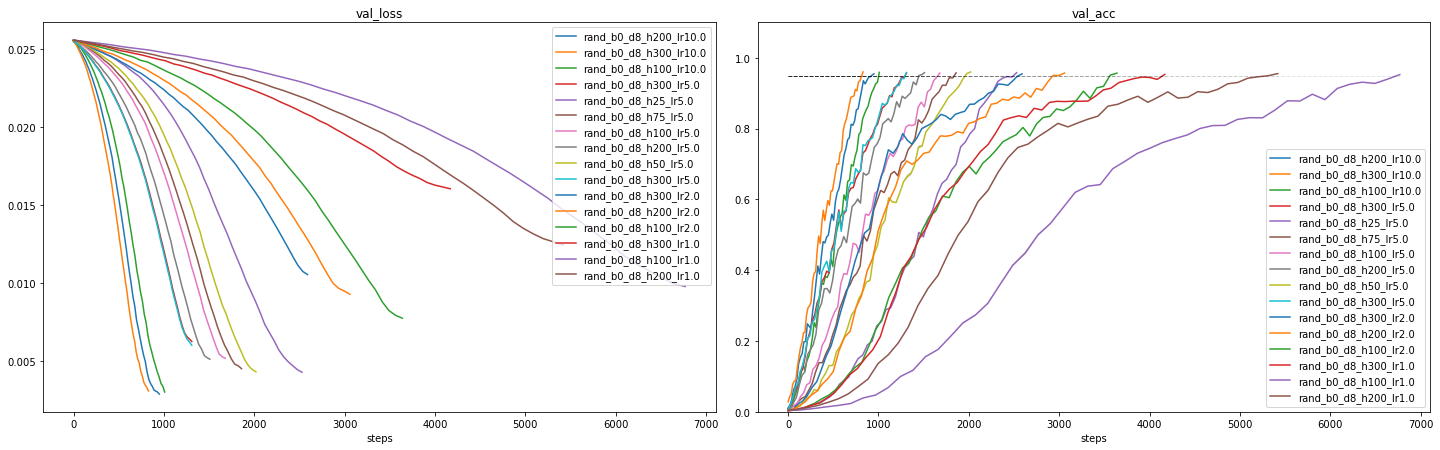

#logged paths : 14 
27158467_2704_2351_synth_rand_b0_d9_h300_lr10.0
fold_2 val_loss 230, val_acc 230, Max_acc: 0.963 val_epoch 230, 
fold_0 val_loss 243, val_acc 243, Max_acc: 0.953 val_epoch 243, 
fold_1 val_loss 246, val_acc 246, Max_acc: 0.953 val_epoch 246, 

27158471_2704_2356_synth_rand_b0_d9_h400_lr10.0
fold_2 val_loss 223, val_acc 223, Max_acc: 0.951 val_epoch 223, 
fold_0 val_loss 225, val_acc 225, Max_acc: 0.959 val_epoch 225, 
fold_1 val_loss 225, val_acc 225, Max_acc: 0.951 val_epoch 225, 

27158475_2804_0005_synth_rand_b0_d9_h500_lr10.0
fold_2 val_loss 207, val_acc 207, Max_acc: 0.953 val_epoch 207, 
fold_0 val_loss 212, val_acc 212, Max_acc: 0.951 val_epoch 212, 
fold_1 val_loss 210, val_acc 210, Max_acc: 0.961 val_epoch 210, 

27146953_2504_1451_synth_rand_b0_d9_h500_lr5.0
fold_2 val_loss 335, val_acc 335, Max_acc: 0.954 val_epoch 335, 
fold_0 val_loss 382, val_acc 382, Max_acc: 0.953 val_epoch 382, 
fold_1 val_loss 376, val_acc 376, Max_acc: 0.956 val_epoch 376, 

27158

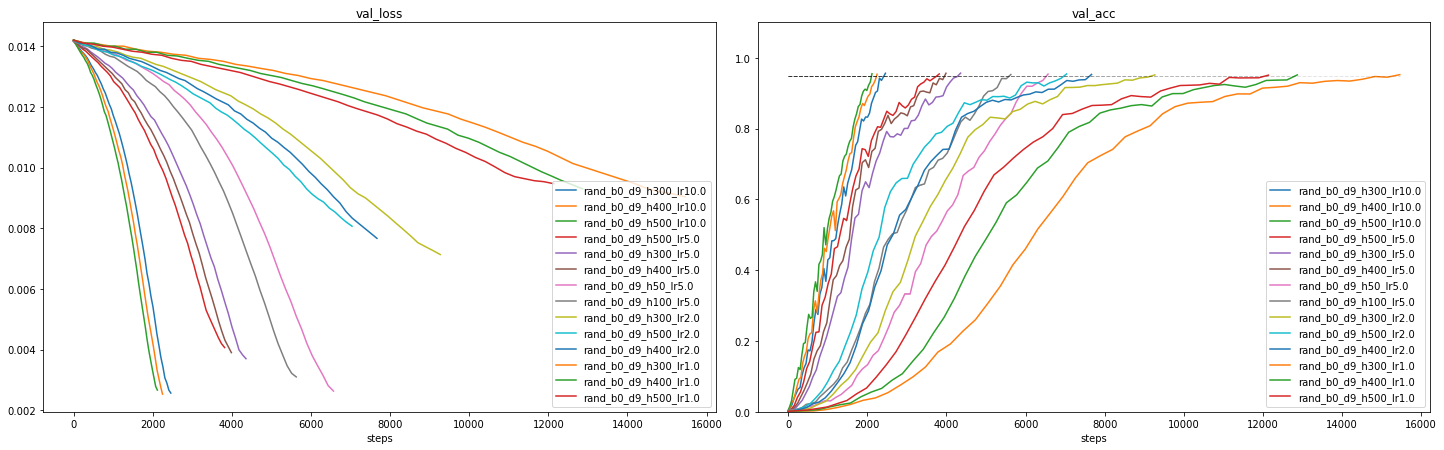

#logged paths : 8 
27172864_2904_2331_synth_rand_b0_d10_h750_lr10.0
fold_2 val_loss 581, val_acc 581, Max_acc: 0.953 val_epoch 581, 
fold_0 val_loss 556, val_acc 556, Max_acc: 0.953 val_epoch 556, 
fold_1 val_loss 580, val_acc 580, Max_acc: 0.953 val_epoch 580, 

27172862_2904_2325_synth_rand_b0_d10_h500_lr10.0
fold_2 val_loss 685, val_acc 685, Max_acc: 0.951 val_epoch 685, 
fold_0 val_loss 682, val_acc 682, Max_acc: 0.953 val_epoch 682, 
fold_1 val_loss 650, val_acc 650, Max_acc: 0.952 val_epoch 650, 

27166166_2904_1754_synth_rand_b0_d10_h400_lr5.0
fold_2 val_loss 911, val_acc 911, Max_acc: 0.864 val_epoch 911, 
fold_0 val_loss 1240, val_acc 1240, Max_acc: 0.951 val_epoch 1240, 
fold_1 val_loss 1251, val_acc 1251, Max_acc: 0.951 val_epoch 1251, 

27156825_2704_1355_synth_rand_b0_d10_h1000_lr5.0
fold_2 val_loss 742, val_acc 742, Max_acc: 0.929 val_epoch 742, 
fold_0 val_loss 787, val_acc 787, Max_acc: 0.951 val_epoch 787, 
fold_1 val_loss 827, val_acc 827, Max_acc: 0.951 val_epoch 827

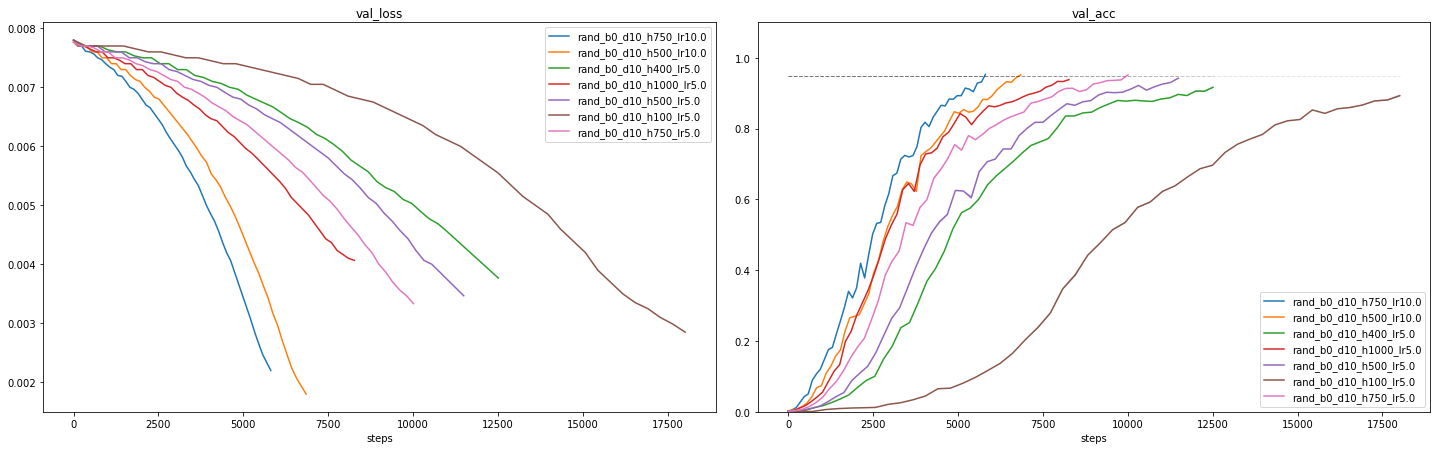

In [345]:

patts_to_search1 = ["rand[a-z0-9_]*d5","rand[a-z0-9_]*d6",
                   "rand[a-z0-9_]*d7[a-z0-9_]*lr5", "rand[a-z0-9_]*d7_h100", "rand[a-z0-9_]*d8_h", "rand[a-z0-9_]*d9_h", "rand[a-z0-9_]*d10_h"]

for patt in patts_to_search1: plot_runs_w_regex(patt, 0.2, LOG_PATH) 

#logged paths : 6 
27156823_2704_1355_synth_um_b0_d5_h25_lr10.0
fold_0 val_loss 1504, val_acc 1504, Max_acc: 0.1 unsuccessful run
27156822_2704_1355_synth_um_b0_d5_h25_lr5.0
fold_0 val_loss 1502, val_acc 1502, Max_acc: 0.103 unsuccessful run
27160125_2804_1104_synth_um_b0_d5_h25_lr5.0
fold_0 val_loss 236, val_acc 236, Max_acc: 0.103 unsuccessful run
27156821_2704_1354_synth_um_b0_d5_h25_lr2.0
fold_2 val_loss 400, val_acc 400, Max_acc: 0.969 val_epoch 400, 
fold_0 val_loss 456, val_acc 456, Max_acc: 0.966 val_epoch 456, 
fold_1 val_loss 428, val_acc 428, Max_acc: 0.953 val_epoch 428, 

27156820_2704_1354_synth_um_b0_d5_h25_lr1.0
fold_0 val_loss 444, val_acc 444, Max_acc: 0.962 val_epoch 444, 

27156819_2704_1354_synth_um_b0_d5_h25_lr0.5
fold_0 val_loss 444, val_acc 444, Max_acc: 0.978 val_epoch 444, 



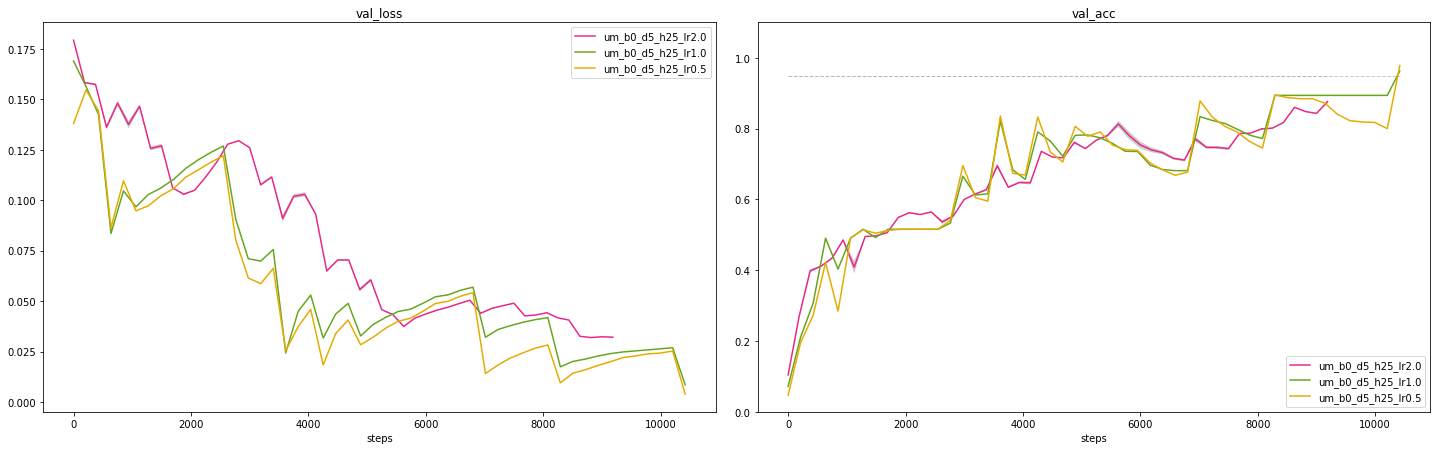

#logged paths : 4 
27158426_2704_2333_synth_um_b0_d6_h25_lr10.0
fold_0 val_loss 1516, val_acc 1516, Max_acc: 0.0797 unsuccessful run
27158424_2704_2334_synth_um_b0_d6_h25_lr5.0
fold_0 val_loss 323, val_acc 323, Max_acc: 0.973 val_epoch 323, 
fold_1 val_loss 458, val_acc 458, Max_acc: 0.978 val_epoch 458, 

27158422_2704_2333_synth_um_b0_d6_h25_lr2.0
fold_0 val_loss 196, val_acc 196, Max_acc: 0.952 val_epoch 196, 
fold_1 val_loss 379, val_acc 379, Max_acc: 0.969 val_epoch 379, 

27158420_2704_2333_synth_um_b0_d6_h25_lr1.0
fold_0 val_loss 216, val_acc 216, Max_acc: 0.958 val_epoch 216, 
fold_1 val_loss 379, val_acc 379, Max_acc: 0.967 val_epoch 379, 



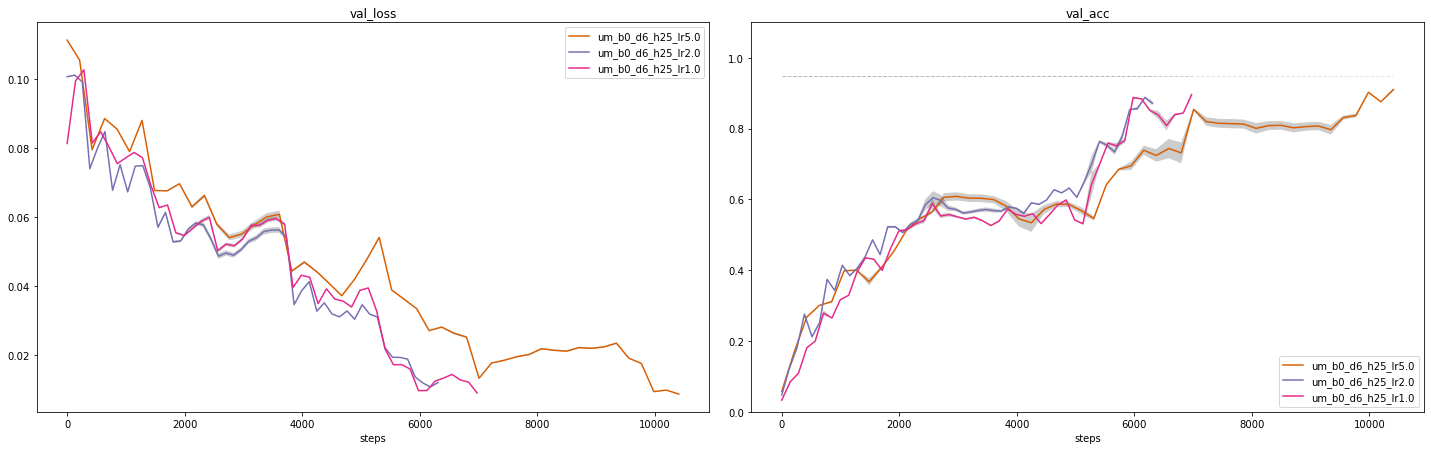

#logged paths : 3 
27157673_2704_2312_synth_um_b0_d7_h100_lr15.0
fold_0 val_loss 1954, val_acc 1954, Max_acc: 0.881 val_epoch 1954, 
fold_1 val_loss 1965, val_acc 1965, Max_acc: 0.859 val_epoch 1965, 

27157671_2704_2312_synth_um_b0_d7_h100_lr10.0
fold_0 val_loss 1999, val_acc 1999, Max_acc: 0.928 val_epoch 1999, 
fold_1 val_loss 1867, val_acc 1867, Max_acc: 0.961 val_epoch 1867, 

27157669_2704_2312_synth_um_b0_d7_h100_lr5.0
fold_0 val_loss 1812, val_acc 1812, Max_acc: 0.954 val_epoch 1812, 
fold_1 val_loss 1844, val_acc 1844, Max_acc: 0.951 val_epoch 1844, 



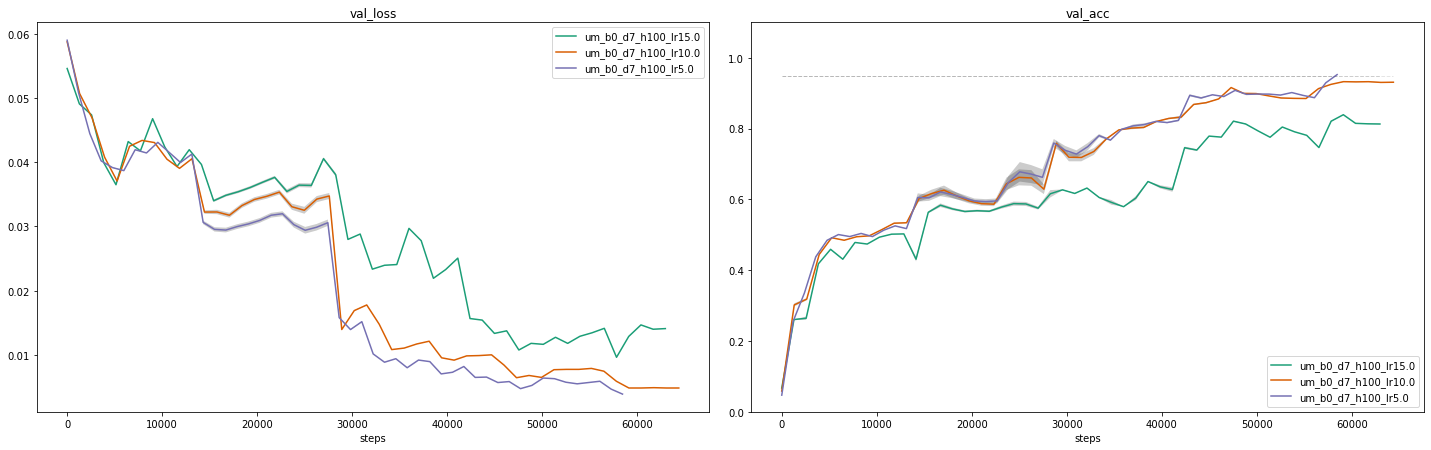

#logged paths : 4 
27160158_2804_2018_synth_um_b0_d8_h200_lr10.0
fold_0 val_loss 1125, val_acc 1125, Max_acc: 0.951 val_epoch 1125, 
fold_1 val_loss 734, val_acc 734, Max_acc: 0.951 val_epoch 734, 

27160156_2804_2006_synth_um_b0_d8_h200_lr5.0
fold_0 val_loss 1126, val_acc 1126, Max_acc: 0.951 val_epoch 1126, 
fold_1 val_loss 738, val_acc 738, Max_acc: 0.953 val_epoch 738, 

27160154_2804_1705_synth_um_b0_d8_h200_lr2.0
fold_0 val_loss 1125, val_acc 1125, Max_acc: 0.957 val_epoch 1125, 
fold_1 val_loss 738, val_acc 738, Max_acc: 0.954 val_epoch 738, 

27160152_2804_1705_synth_um_b0_d8_h200_lr1.0
fold_0 val_loss 1125, val_acc 1125, Max_acc: 0.962 val_epoch 1125, 



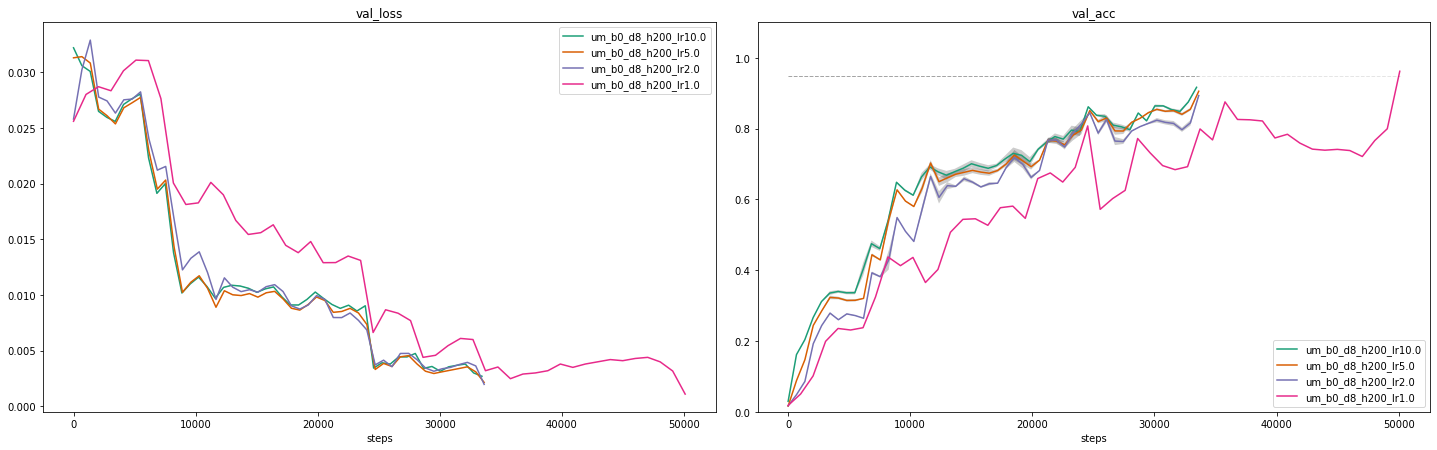

#logged paths : 1 
27147230_2504_1618_synth_um_b0_d9_h500_lr5.0
fold_0 val_loss 570, val_acc 570, Max_acc: 0.951 val_epoch 570, 



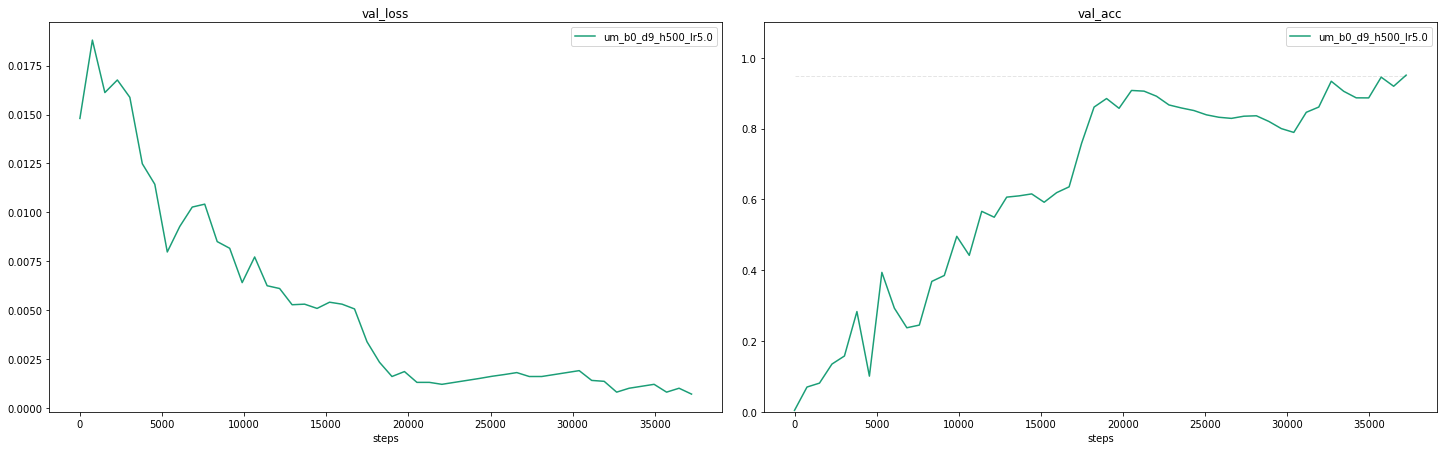

In [310]:
patts_to_search2 = ["um_b0[a-z0-9_]*d5_h25","um_b0[a-z0-9_]*d6_h25", "um_b0[a-z0-9_]*d7_h100", "um_b0[a-z0-9_]*d8_h200", "um_b0[a-z0-9_]*d9_h500"]
for patt in patts_to_search2: plot_runs_w_regex(patt, 0.2, LOG_PATH)


#logged paths : 6 
27156823_2704_1355_synth_um_b0_d5_h25_lr10.0
fold_0 val_loss 1504, val_acc 1504, Max_acc: 0.1 unsuccessful run
27156822_2704_1355_synth_um_b0_d5_h25_lr5.0
fold_0 val_loss 1502, val_acc 1502, Max_acc: 0.103 unsuccessful run
27160125_2804_1104_synth_um_b0_d5_h25_lr5.0
fold_0 val_loss 236, val_acc 236, Max_acc: 0.103 unsuccessful run
27156821_2704_1354_synth_um_b0_d5_h25_lr2.0
fold_2 val_loss 400, val_acc 400, Max_acc: 0.969 val_epoch 400, 
fold_0 val_loss 456, val_acc 456, Max_acc: 0.966 val_epoch 456, 
fold_1 val_loss 428, val_acc 428, Max_acc: 0.953 val_epoch 428, 

27156820_2704_1354_synth_um_b0_d5_h25_lr1.0
fold_0 val_loss 444, val_acc 444, Max_acc: 0.962 val_epoch 444, 

27156819_2704_1354_synth_um_b0_d5_h25_lr0.5
fold_0 val_loss 444, val_acc 444, Max_acc: 0.978 val_epoch 444, 



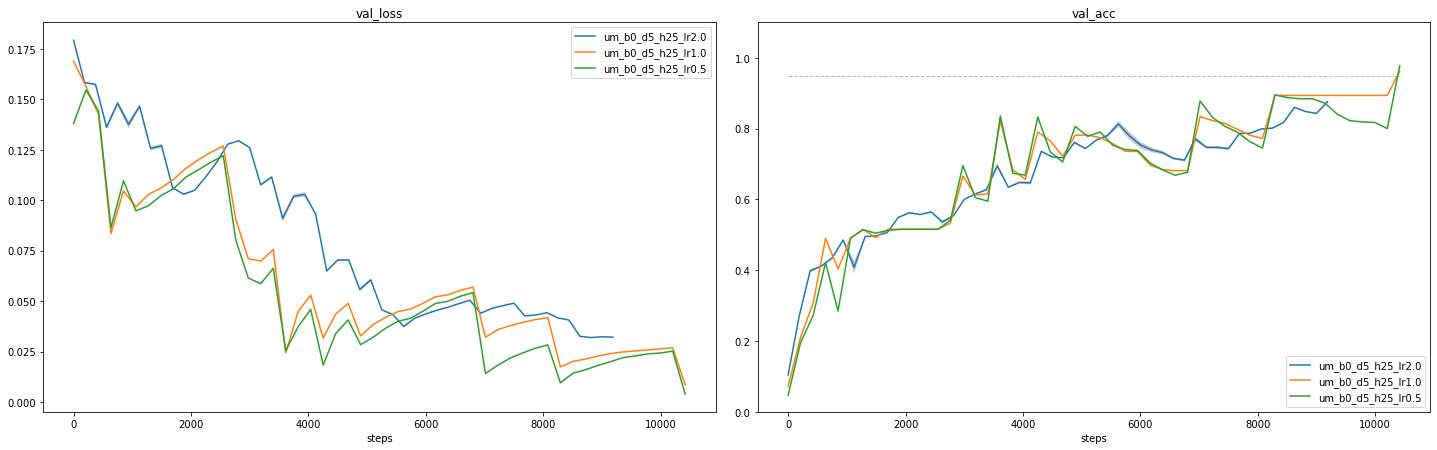

#logged paths : 4 
27158426_2704_2333_synth_um_b0_d6_h25_lr10.0
fold_0 val_loss 1516, val_acc 1516, Max_acc: 0.0797 unsuccessful run
27158424_2704_2334_synth_um_b0_d6_h25_lr5.0
fold_0 val_loss 323, val_acc 323, Max_acc: 0.973 val_epoch 323, 
fold_1 val_loss 458, val_acc 458, Max_acc: 0.978 val_epoch 458, 

27158422_2704_2333_synth_um_b0_d6_h25_lr2.0
fold_0 val_loss 196, val_acc 196, Max_acc: 0.952 val_epoch 196, 
fold_1 val_loss 379, val_acc 379, Max_acc: 0.969 val_epoch 379, 

27158420_2704_2333_synth_um_b0_d6_h25_lr1.0
fold_0 val_loss 216, val_acc 216, Max_acc: 0.958 val_epoch 216, 
fold_1 val_loss 379, val_acc 379, Max_acc: 0.967 val_epoch 379, 



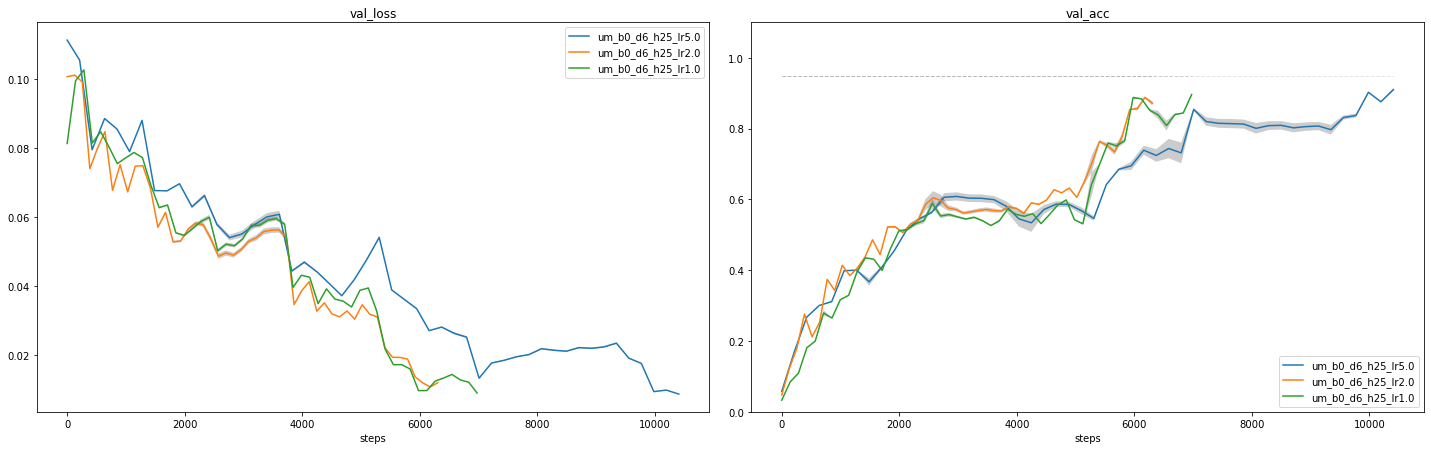

#logged paths : 14 
27157679_2704_2312_synth_um_b0_d7_h250_lr15.0
fold_0 val_loss 1873, val_acc 1873, Max_acc: 0.765 unsuccessful run
27157673_2704_2312_synth_um_b0_d7_h100_lr15.0
fold_0 val_loss 1954, val_acc 1954, Max_acc: 0.881 val_epoch 1954, 
fold_1 val_loss 1965, val_acc 1965, Max_acc: 0.859 val_epoch 1965, 

27160134_2804_1104_synth_um_b0_d7_h50_lr10.0
fold_0 val_loss 2050, val_acc 2050, Max_acc: 0.919 val_epoch 2050, 
fold_1 val_loss 2107, val_acc 2107, Max_acc: 0.943 val_epoch 2107, 

27157671_2704_2312_synth_um_b0_d7_h100_lr10.0
fold_0 val_loss 1999, val_acc 1999, Max_acc: 0.928 val_epoch 1999, 
fold_1 val_loss 1867, val_acc 1867, Max_acc: 0.961 val_epoch 1867, 

27149336_2604_1539_synth_um_b0_d7_h250_lr10.0
fold_0 val_loss 763, val_acc 763, Max_acc: 0.512 unsuccessful run
27149339_2604_1541_synth_um_b0_d7_h150_lr5.0
fold_0 val_loss 849, val_acc 849, Max_acc: 0.512 unsuccessful run
27157675_2704_2312_synth_um_b0_d7_h250_lr5.0
fold_0 val_loss 1799, val_acc 1799, Max_acc: 0.958

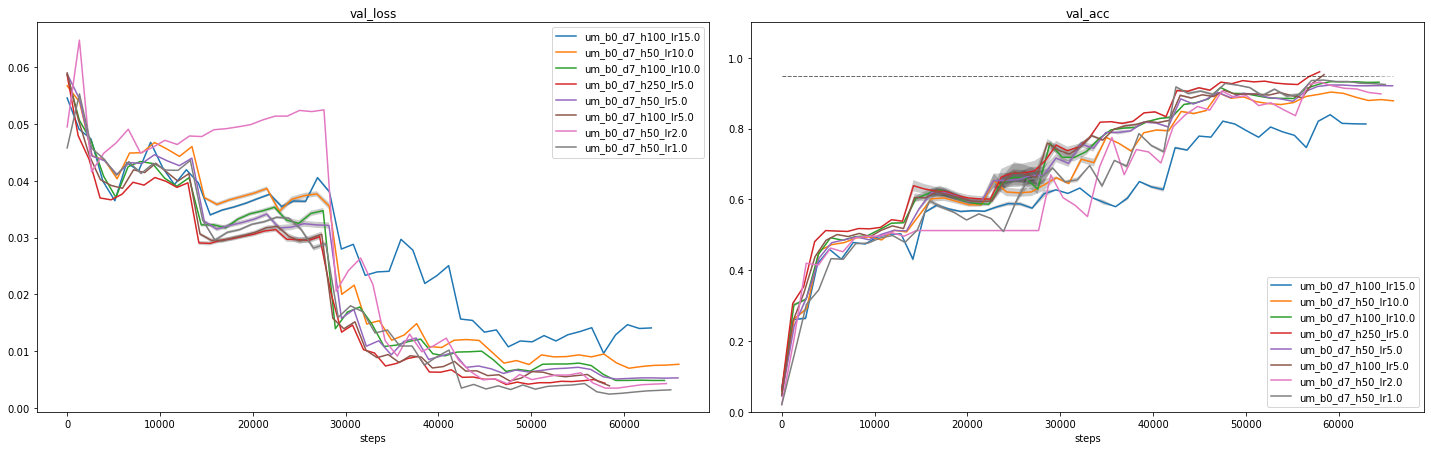

#logged paths : 9 
27160143_2804_1705_synth_um_b0_d8_h100_lr10.0
fold_0 val_loss 1181, val_acc 1181, Max_acc: 0.951 val_epoch 1181, 
fold_1 val_loss 725, val_acc 725, Max_acc: 0.958 val_epoch 725, 

27160158_2804_2018_synth_um_b0_d8_h200_lr10.0
fold_0 val_loss 1125, val_acc 1125, Max_acc: 0.951 val_epoch 1125, 
fold_1 val_loss 734, val_acc 734, Max_acc: 0.951 val_epoch 734, 

27147228_2504_1617_synth_um_b0_d8_h300_lr5.0
fold_0 val_loss 972, val_acc 972, Max_acc: 0.947 val_epoch 972, 

27160141_2804_1642_synth_um_b0_d8_h100_lr5.0
fold_0 val_loss 1328, val_acc 1328, Max_acc: 0.933 val_epoch 1328, 
fold_1 val_loss 843, val_acc 843, Max_acc: 0.954 val_epoch 843, 

27160156_2804_2006_synth_um_b0_d8_h200_lr5.0
fold_0 val_loss 1126, val_acc 1126, Max_acc: 0.951 val_epoch 1126, 
fold_1 val_loss 738, val_acc 738, Max_acc: 0.953 val_epoch 738, 

27160154_2804_1705_synth_um_b0_d8_h200_lr2.0
fold_0 val_loss 1125, val_acc 1125, Max_acc: 0.957 val_epoch 1125, 
fold_1 val_loss 738, val_acc 738, Max_a

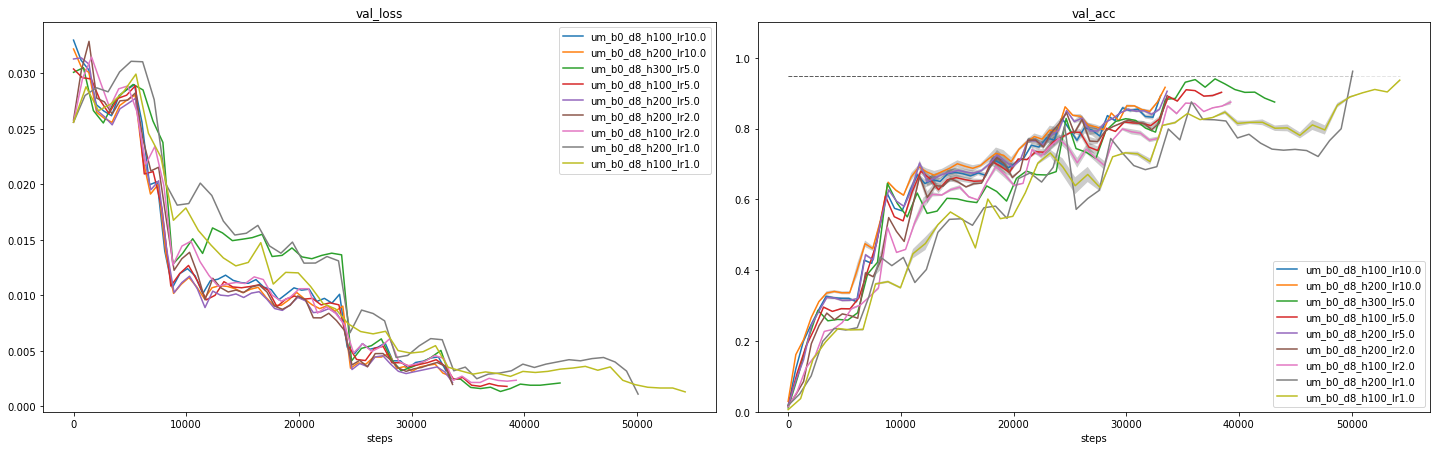

#logged paths : 5 
27160167_2804_2149_synth_um_b0_d9_h300_lr10.0
fold_0 val_loss 617, val_acc 617, Max_acc: 0.951 val_epoch 617, 
fold_1 val_loss 477, val_acc 477, Max_acc: 0.955 val_epoch 477, 

27160165_2804_2118_synth_um_b0_d9_h300_lr5.0
fold_0 val_loss 621, val_acc 621, Max_acc: 0.951 val_epoch 621, 
fold_1 val_loss 489, val_acc 489, Max_acc: 0.953 val_epoch 489, 

27147230_2504_1618_synth_um_b0_d9_h500_lr5.0
fold_0 val_loss 570, val_acc 570, Max_acc: 0.951 val_epoch 570, 

27160163_2804_2111_synth_um_b0_d9_h300_lr2.0
fold_0 val_loss 729, val_acc 729, Max_acc: 0.958 val_epoch 729, 
fold_1 val_loss 664, val_acc 664, Max_acc: 0.952 val_epoch 664, 

27160161_2804_2053_synth_um_b0_d9_h300_lr1.0
fold_0 val_loss 861, val_acc 861, Max_acc: 0.953 val_epoch 861, 
fold_1 val_loss 834, val_acc 834, Max_acc: 0.948 val_epoch 834, 



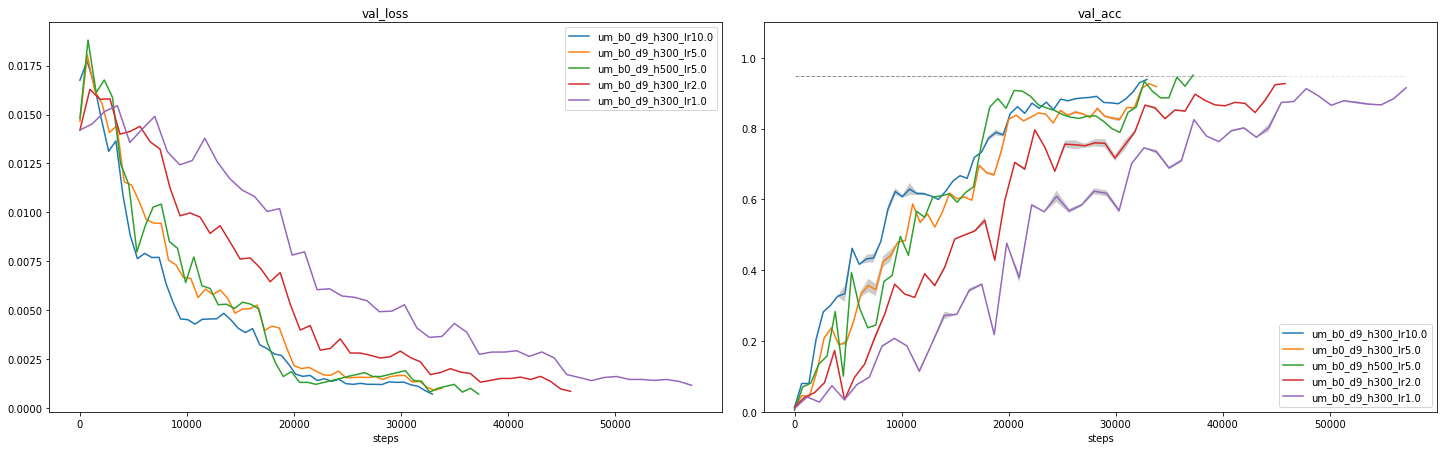

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#logged paths : 0 


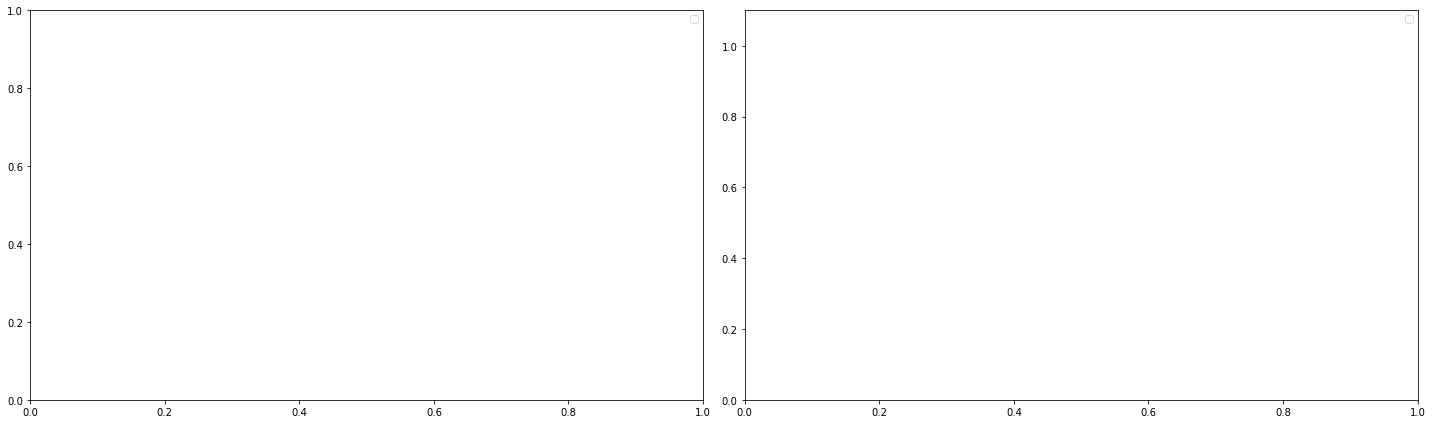

In [328]:
patts_to_search2 = ["um_b0_d5", "um_b0_d6", "um_b0_d7", "um_b0_d8",
                    "um_b0_d9", "um_b0_d10"]
for patt in patts_to_search2: plot_runs_w_regex(patt, 0.8, LOG_PATH)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


#logged paths : 0 


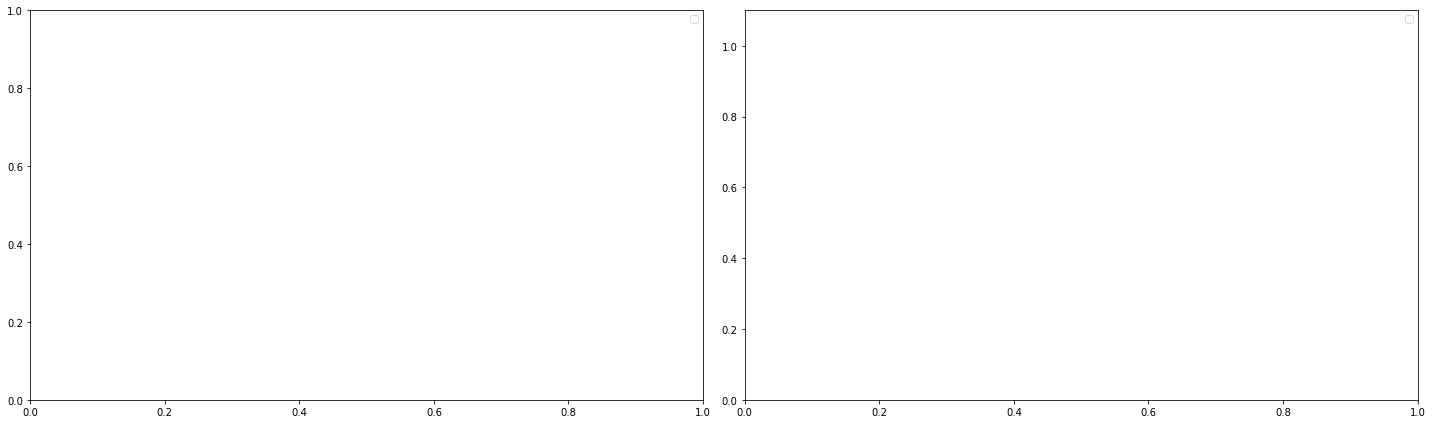

#logged paths : 0 


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


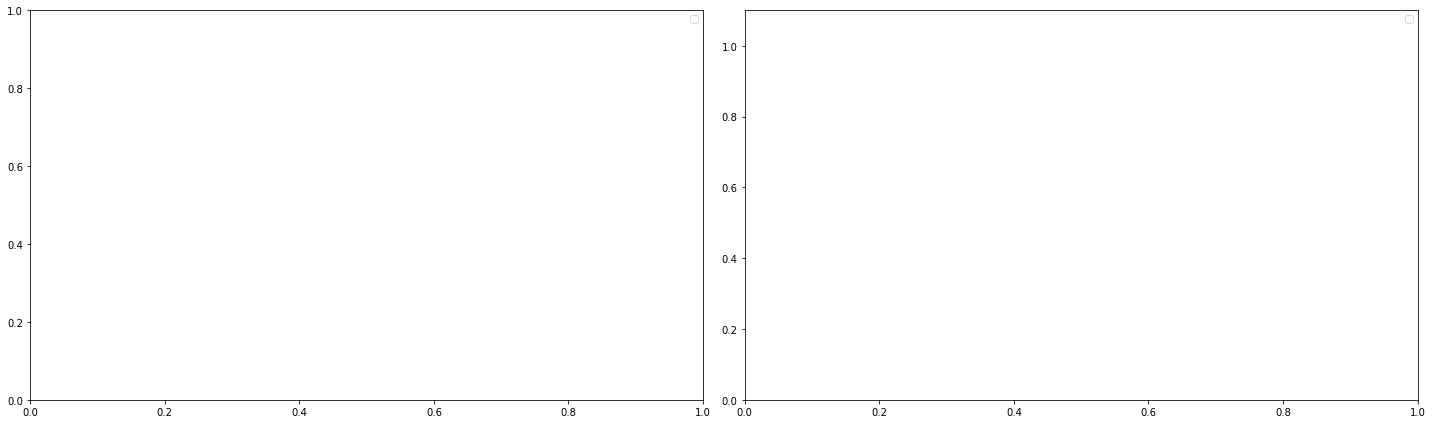

#logged paths : 8 
27174489_3004_1323_synth_um_b1_d7_h100_lr5.0
fold_0 val_loss 8, val_acc 8, Max_acc: 1.0 val_epoch 8, 

27174490_3004_1323_synth_um_b1_d7_h100_lr5.0
fold_1 val_loss 7, val_acc 7, Max_acc: 1.0 val_epoch 7, 

27174430_3004_1129_synth_um_b10_d7_h100_lr2.0
fold_0 val_loss 9, val_acc 9, Max_acc: 0.512 val_epoch 9, 

27174431_3004_1106_synth_um_b10_d7_h100_lr2.0
fold_1 val_loss 9, val_acc 9, Max_acc: 1.0 val_epoch 9, 

27174433_3004_1221_synth_um_b100_d7_h100_lr2.0
fold_1 val_loss 12, val_acc 12, Max_acc: 1.0 val_epoch 12, 

27174432_3004_1137_synth_um_b100_d7_h100_lr2.0
fold_0 val_loss 12, val_acc 12, Max_acc: 0.699 val_epoch 12, 

27174434_3004_1232_synth_um_b1000_d7_h100_lr2.0
fold_0 val_loss 19, val_acc 19, Max_acc: 0.837 val_epoch 19, 

27174435_3004_1257_synth_um_b1000_d7_h100_lr2.0
fold_1 val_loss 19, val_acc 19, Max_acc: 0.783 val_epoch 19, 



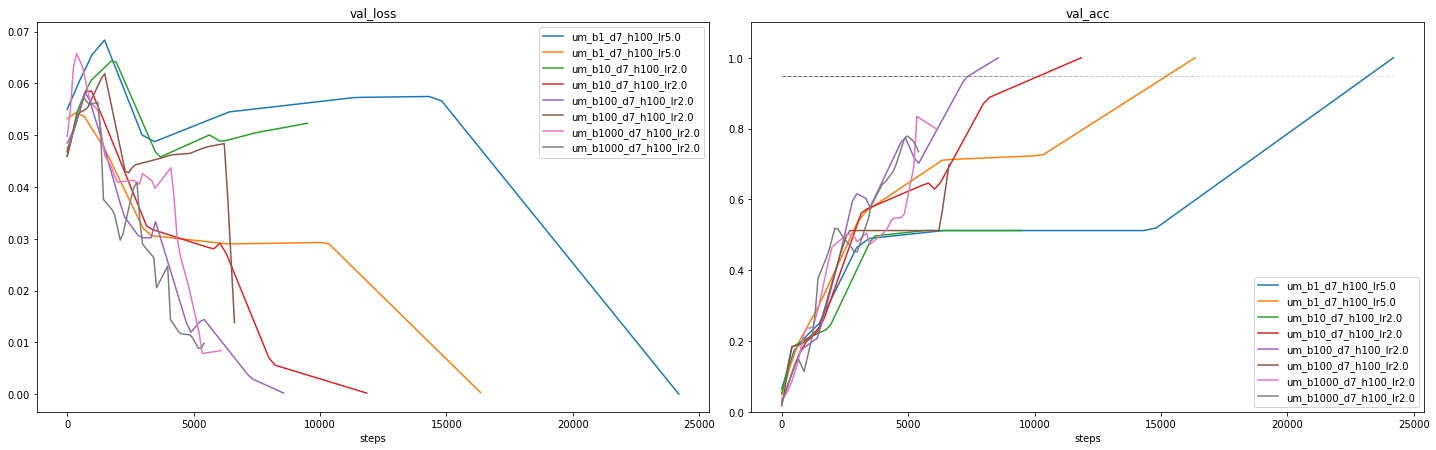

#logged paths : 2 
27174449_3004_1301_synth_um_b1000_d8_h300_lr5.0
fold_1 val_loss 16, val_acc 16, Max_acc: 0.936 val_epoch 16, 

27174448_3004_1246_synth_um_b1000_d8_h300_lr5.0
fold_0 val_loss 16, val_acc 16, Max_acc: 0.818 val_epoch 16, 



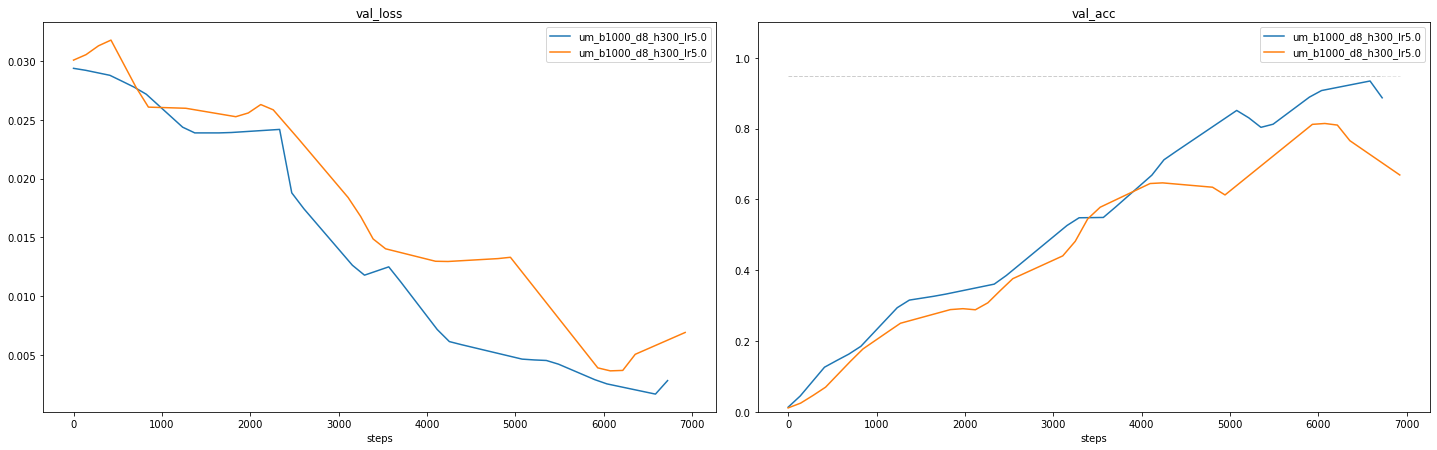

#logged paths : 4 
27174495_3004_1443_synth_um_b1000_d9_h500_lr5.0
fold_0 val_loss 10, val_acc 10, Max_acc: 0.856 val_epoch 10, 

27174493_3004_1430_synth_um_b1000_d9_h300_lr5.0
fold_0 val_loss 10, val_acc 10, Max_acc: 0.836 val_epoch 10, 

27174496_3004_1449_synth_um_b1000_d9_h500_lr5.0
fold_1 val_loss 9, val_acc 9, Max_acc: 0.864 val_epoch 9, 

27174494_3004_1434_synth_um_b1000_d9_h300_lr5.0
fold_1 val_loss 9, val_acc 9, Max_acc: 0.811 val_epoch 9, 



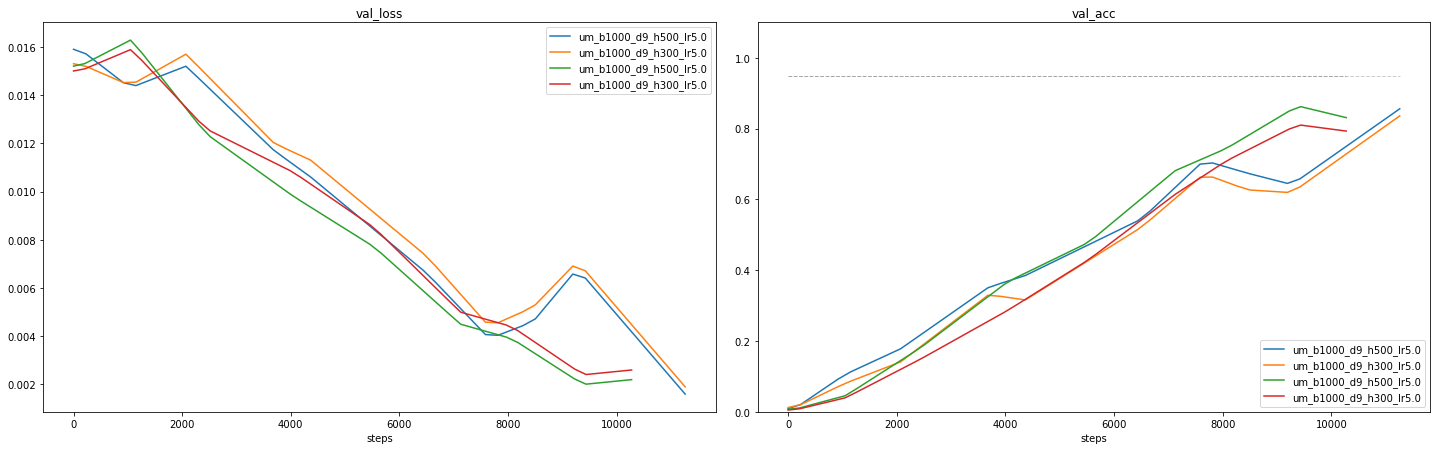

#logged paths : 20 
27174499_3004_1449_synth_um_b0_d10_h500_lr10.0
fold_0 val_loss 334, val_acc 334, Max_acc: 0.952 val_epoch 334, 

27174509_3004_1527_synth_um_b0_d10_h750_lr10.0
fold_0 val_loss 332, val_acc 332, Max_acc: 0.954 val_epoch 332, 

27174510_3004_1529_synth_um_b0_d10_h750_lr10.0
fold_1 val_loss 291, val_acc 291, Max_acc: 0.958 val_epoch 291, 

27174500_3004_1455_synth_um_b0_d10_h500_lr10.0
fold_1 val_loss 292, val_acc 292, Max_acc: 0.954 val_epoch 292, 

27174502_3004_1503_synth_um_b1_d10_h500_lr10.0
fold_1 val_loss 5, val_acc 5, Max_acc: 0.976 val_epoch 5, 

27174501_3004_1456_synth_um_b1_d10_h500_lr10.0
fold_0 val_loss 5, val_acc 5, Max_acc: 0.99 val_epoch 5, 

27174512_3004_1540_synth_um_b1_d10_h750_lr10.0
fold_1 val_loss 5, val_acc 5, Max_acc: 0.979 val_epoch 5, 

27174511_3004_1539_synth_um_b1_d10_h750_lr10.0
fold_0 val_loss 5, val_acc 5, Max_acc: 0.991 val_epoch 5, 

27174513_3004_1542_synth_um_b10_d10_h750_lr10.0
fold_0 val_loss 5, val_acc 5, Max_acc: 0.978 val_epoc

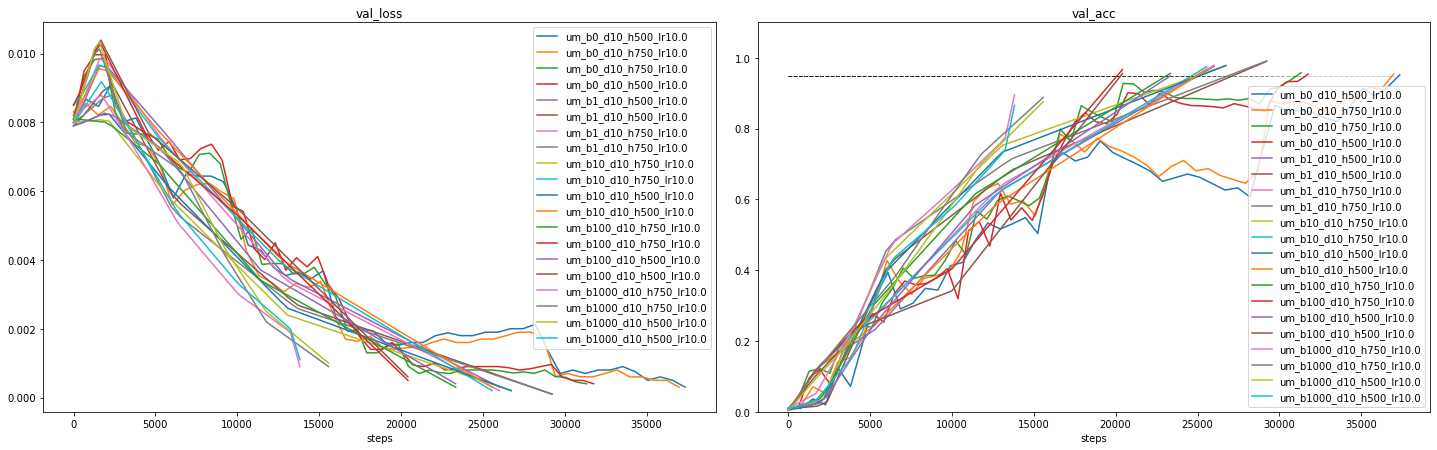

In [347]:
patts_to_search2 = ["um_b0_d5", "um_b0_d6", "um_b0_d7", "um_b0_d8", "um_b0_d9", "um_b0_d10", 
                    "rand_b0_d5", "rand_b0_d6", "rand_b0_d7", "rand_b0_d8", "rand_b0_d9", "rand_b0_d10"]

patts_to_search2 = ["d5", "d6", "d7", "d8", "d9", "d10"]
for patt in patts_to_search2: plot_runs_w_regex(patt, 0.3, DL_LOG_PATH)

# Log folds merger

In [333]:
import shutil
import itertools
from collections import Counter
from more_itertools import locate

def merge_folds(log_path=LOG_PATH):
    all_ckpt_dirs = os.listdir(log_path)
    all_ckpt_dirs = [el for el in all_ckpt_dirs if "DS_Store" not in el]
    #all_ckpt_dirs = [el for el in all_ckpt_dirs if re.search(re_patt_to_search, el)]
    patt = "([0-9]+)_[0-9]+_[0-9]+_[a-z]+_((?:um|rand)_b[0-9]+_d[0-9]+_h[0-9]+_lr[0-9]+)"
    matched = [re.match(patt, el) for el in all_ckpt_dirs]
    idx_true = [int(m.group(1)) > 27149332 for m in matched] # keep only recent matches
    matched = np.array(matched)[idx_true]
    all_ckpt_dirs = np.array(all_ckpt_dirs)[idx_true]
    hashes = [el.group(2) for el in matched] # create hashes
    counts = Counter(hashes)
    dup_hashes = [i for i in counts.keys() if counts[i] > 1] # keep only ckpts w duplicates
    
    folds_to_merge = [all_ckpt_dirs[list(locate(hashes, lambda x: x == hash1))] for hash1 in dup_hashes] # get the actual paths
    print(folds_to_merge)
    
    all_ckpt_dirs = [[join(log_path, fold) for fold in folds] for folds in folds_to_merge]
    for folds in all_ckpt_dirs: 
        for fold in folds: assert(os.path.isdir(fold))
    
    for folds in all_ckpt_dirs:
        # find fold 0
        for i, fold in enumerate(folds):
            list_metrics_fold_x = os.listdir(fold)
            fold_x = [el for el in list_metrics_fold_x if ("metrics" not in el and "DS_Store" not in el)][0]
            fold_nb = int(re.match('fold_([0-9]+)', fold_x).group(1))
            if fold_nb == 0:
                del folds[i]
            
            dest_path = join(fold, "metrics")
        
        merged_folds_nb = [0]
        for fold in folds:
            list_metrics_fold_x = os.listdir(fold)
            fold_x = [el for el in list_metrics_fold_x if ("metrics" not in el and "DS_Store" not in el)][0]
            foldnb2 = int(re.match('fold_([0-9]+)', fold_x).group(1))
            
            metrics_fold = join(fold, "metrics")
            dirs_list = os.listdir(metrics_fold)
            if len(dirs_list) < 1:
                continue
            source_path = join(metrics_fold, dirs_list[0])
            
            print('dest_fold_nb', dest_path, merged_folds_nb, 'foldnb2', source_path, foldnb2)
            if not foldnb2 in merged_folds_nb:
                merged_folds_nb.append(foldnb2)

                # Check if file already exists
                hyp_dest_path = join(dest_path, f'fold_{foldnb2}')
                if os.path.isdir(hyp_dest_path):
                    print(hyp_dest_path,'exists in the destination path!')
                    shutil.rmtree(hyp_dest_path)

                shutil.move(source_path, dest_path)

                folder = source_path[:source_path[:source_path.rfind('/')].rfind('/')]
                print("TO remove", folder)
                shutil.rmtree(folder)

#27147228_2504_1617_synth_um_b0_d8_h300_lr5
merge_folds(DL_LOG_PATH)


[array(['27172704_2904_2239_synth_um_b0_d5_h50_lr2.0',
       '27172705_2904_2239_synth_um_b0_d5_h50_lr2.0'], dtype='<U49'), array(['27172895_3004_0318_synth_um_b0_d10_h1000_lr2.0',
       '27172894_3004_0304_synth_um_b0_d10_h1000_lr2.0'], dtype='<U49'), array(['27166074_2904_1631_synth_um_b0_d7_h100_lr2.0',
       '27166075_2904_1631_synth_um_b0_d7_h100_lr2.0'], dtype='<U49'), array(['27172712_2904_2245_synth_um_b0_d6_h50_lr5.0',
       '27172711_2904_2242_synth_um_b0_d6_h50_lr5.0'], dtype='<U49'), array(['27166087_2904_1707_synth_um_b10_d7_h100_lr5.0',
       '27166086_2904_1707_synth_um_b10_d7_h100_lr5.0'], dtype='<U49'), array(['27172896_3004_0319_synth_um_b0_d10_h1000_lr5.0',
       '27172897_3004_0320_synth_um_b0_d10_h1000_lr5.0'], dtype='<U49'), array(['27172868_2904_2334_synth_um_b0_d7_h200_lr5.0',
       '27172869_2904_2334_synth_um_b0_d7_h200_lr5.0'], dtype='<U49'), array(['27166091_2904_1713_synth_um_b1000_d7_h100_lr5.0',
       '27166090_2904_1713_synth_um_b1000_d7_h100_lr5